<a href="https://colab.research.google.com/github/anggaangoro3/Prediksi-Harga-Tanah-Jakarta/blob/main/Jakarta_land_price_analysis_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Mount Drive dan Import Libraries
# Google Colab
from google.colab import drive

# Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import lightgbm as lgb
import joblib
import pickle
import re
import time
import warnings
warnings.filterwarnings('ignore')


# Settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Cell 2:
# Load datasets
df_gabungan = pd.read_csv('/content/drive/MyDrive/Rumah123_dataset/GABUNGAN_FINAL_DATASET.csv')
df_baru99co = pd.read_csv('/content/drive/MyDrive/Rumah123_dataset/baru99co.csv')

print("Dataset 1 (GABUNGAN_FINAL_DATASET.csv) shape:", df_gabungan.shape)
print("Dataset 2 (baru99co.csv) shape:", df_baru99co.shape)
print("\nKolom yang tersedia di kedua dataset:")
print(df_gabungan.columns.tolist())

# Gabungkan data
raw_df = pd.concat([df_gabungan, df_baru99co], ignore_index=True)
raw_df = raw_df.reset_index().rename(columns={'index': 'NO'})

print("\n Total data setelah digabung:", raw_df.shape[0])
print(" Total kolom:", raw_df.shape[1])

# Quick inspection
print("\n5 contoh data mentah:")
display(raw_df.head(5))

Dataset 1 (GABUNGAN_FINAL_DATASET.csv) shape: (2398, 13)
Dataset 2 (baru99co.csv) shape: (875, 13)

Kolom yang tersedia di kedua dataset:
['Product_sku_0', 'Place_name_0', 'Total_Price_0', 'Price_per_meter_0', 'Land_Area_0', 'Certificate_0', 'Land_Dimensions_0', 'Property_Type_0', 'Ad_Type_0', 'Place_PostalAddress_addressLocality_0', 'BreadcrumbList_ListItem_name_2', 'BreadcrumbList_ListItem_name_3', 'Product_description_0']

 Total data setelah digabung: 3273
 Total kolom: 14

5 contoh data mentah:


,NO,Product_sku_0,Place_name_0,Total_Price_0,Price_per_meter_0,Land_Area_0,Certificate_0,Land_Dimensions_0,Property_Type_0,Ad_Type_0,Place_PostalAddress_addressLocality_0,BreadcrumbList_ListItem_name_2,BreadcrumbList_ListItem_name_3,Product_description_0
0,0,las8899959,Dijual Kavling Pulau Opak New Cluster Permata ...,"Rp 4,75 Miliar Total",Rp 33 Juta /m²,144 m² (18x8m),PPJB,18x8 m,Tanah,Dijual,"Permata Buana, Jakarta Barat",Jakarta Barat,Permata Buana,For sale di wilayah yang tenang. Dengan katego...
1,1,Dijual,Kemang Pejaten Barat Raya Nempel Njop Bisa Ban...,"Rp 47,3 Miliar Total","Rp 18,5 Juta /m²",2561 m² (90x28m),SHM,90x28 m,Ada,Tanah,"Kemang, Jakarta Selatan",Jakarta Selatan,Kemang,Lahan Kosong di Jalan Pejaten Barat Raya bisa ...
2,2,las8971423,DI JUAL TANAH KOMERSIL TEPI JALAN CAWANG,Rp 17 Miliar Total,NaN,497 m²,SHM,NaN,Tanah,Dijual,"Cawang, Jakarta Timur",Jakarta Timur,Cawang,"DI Jual Tanah di Cawang, Jakarta Timur.\n\n- S..."
3,3,las8706550,Kavling Di Cluster The Piano at Golf Island PI...,"Rp 6,25 Miliar Total",Rp 25 Juta /m²,250 m² (25x10m),PPJB,25x10 m,Tanah,Dijual,"Pantai Indah Kapuk, Jakarta Utara",Jakarta Utara,Pantai Indah Kapuk,Pantai Indah Kapuk PIK Golf Island\nCluster Th...
4,4,las8706566,Kavling Hoek Di Cluster The Piano at Golf Isla...,"Rp 9,37 Miliar Total",Rp 25 Juta /m²,375 m² (25x15m),Lainnya,25x15 m,Tanah,Dijual,"Pantai Indah Kapuk 2, Jakarta Utara",Jakarta Utara,Pantai Indah Kapuk 2,Pantai Indah Kapuk PIK Golf Island\nCluster Th...


In [ ]:
#Cell 3: Basic Cleaning (URL & Duplicates)
# 1. Hapus baris dengan URL di kolom Place_name_0
mask_url = raw_df['Place_name_0'].astype(str).str.contains('www.rumah123.com', na=False)
if mask_url.sum() > 0:
    print(f" Menghapus {mask_url.sum()} baris dengan URL di 'Place_name_0'...")
    cleaned_df = raw_df[~mask_url].reset_index(drop=True)
else:
    cleaned_df = raw_df.copy()
    print(" Tidak ditemukan baris dengan URL")
print(f"Jumlah baris dengan 'www.rumah123' di 'Place_name_0': {len(mask_url)}")

if len(mask_url) > 0:
    print("\n10 contoh baris:")
    display(mask_url.head(10))
    print("\nDropping rows with 'www.rumah123' in 'Place_name_0'...")
    cleaned_df = cleaned_df[~mask_url].reset_index(drop=True)
    cleaned_df['NO'] = cleaned_df.index
    print(f"New total rows: {len(mask_url)}")
else:
    print("\nTidak ada baris yang ditemukan dengan 'www.rumah123' di 'Place_name_0'.")

# 2. Deteksi dan hapus duplikat berdasarkan kolom kunci
key_columns = ['Place_name_0', 'Total_Price_0', 'BreadcrumbList_ListItem_name_2']
duplicates = cleaned_df.duplicated(subset=key_columns, keep=False)
print(f"\n Jumlah duplikat terdeteksi: {duplicates.sum()}")

# Hapus duplikat
if duplicates.sum() > 0:
    before = len(cleaned_df)
    cleaned_df = cleaned_df.drop_duplicates(subset=key_columns, keep='first').reset_index(drop=True)
    after = len(cleaned_df)
    print(f" Duplikat berhasil dihapus: {before-after} baris")
else:
    print(" Tidak ada duplikat yang ditemukan")

# Perbarui nomor urut
cleaned_df['NO'] = range(len(cleaned_df))
print(f"\n Ukuran akhir setelah cleaning: {cleaned_df.shape}")

# Standardisasi kapitalisasi nama area secara otomatis
def standardize_area_name(area_name):
    """Menstandarkan kapitalisasi nama area dengan penanganan khusus untuk nama tempat Jakarta"""
    if pd.isna(area_name) or not isinstance(area_name, str):
        return area_name

    area_name = area_name.strip()

    # Daftar pengecualian untuk nama tempat yang memiliki format khusus
    special_cases = {
        'scbd': 'SCBD',
        'Setia Budi': 'Setiabudi',
        'setia budi': 'Setiabudi',
        'pik': 'Pantai Indah Kapuk',
        'PIK': 'Pantai Indah Kapuk',
        'pantai indah kapuk': 'Pantai Indah Kapuk',
        'pantai indah kapuk 2': 'Pantai Indah Kapuk dua',
        'cempaka putih': 'Cempaka Putih',
        'bendungan hilir': 'Bendungan Hilir',
        'duren sawit': 'Duren Sawit',
        'kalimalang': 'Kalimalang'
    }

    # Konversi ke lowercase untuk matching
    lower_name = area_name.lower()

    # Periksa apakah ada di daftar pengecualian
    for pattern, formatted_name in special_cases.items():
        if pattern in lower_name:
            return formatted_name

    # Untuk kasus umum, gunakan title case
    # Tapi pertama-tama, pisahkan kata-kata
    words = re.split(r'(\s+)', area_name)  # Mempertahankan spasi
    standardized_words = []

    for word in words:
        if word.strip() == '':
            standardized_words.append(word)  # Pertahankan spasi
            continue

        # Handle angka dan simbol
        if any(char.isdigit() for char in word):
            # Jika mengandung angka, pertahankan format asli tapi title case untuk teks
            parts = re.split(r'(\d+)', word)
            formatted_parts = [p.title() if p.isalpha() else p for p in parts]
            standardized_words.append(''.join(formatted_parts))
        else:
            # Gunakan title case untuk kata biasa
            standardized_words.append(word.title())

    return ''.join(standardized_words)

# Terapkan fungsi ke kolom area
print("\n Menstandarkan kapitalisasi nama area secara otomatis...")
before_count = cleaned_df['BreadcrumbList_ListItem_name_3'].nunique()
cleaned_df['BreadcrumbList_ListItem_name_3'] = cleaned_df['BreadcrumbList_ListItem_name_3'].apply(standardize_area_name)
after_count = cleaned_df['BreadcrumbList_ListItem_name_3'].nunique()

print(f" Standardisasi selesai!")
print(f"Jumlah kategori unik sebelum: {before_count}")
print(f"Jumlah kategori unik setelah: {after_count}")
print(f"Pengurangan kategori: {before_count - after_count}")

# Tampilkan contoh hasil
print("\nContoh hasil standardisasi:")
sample_areas = cleaned_df['BreadcrumbList_ListItem_name_3'].sample(10).tolist()
for area in sample_areas:
    print(f"  - {area}")

 Menghapus 23 baris dengan URL di 'Place_name_0'...
Jumlah baris dengan 'www.rumah123' di 'Place_name_0': 3273

10 contoh baris:


,Place_name_0
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,False



Dropping rows with 'www.rumah123' in 'Place_name_0'...
New total rows: 3273

 Jumlah duplikat terdeteksi: 2152
 Duplikat berhasil dihapus: 1251 baris

 Ukuran akhir setelah cleaning: (1976, 14)

 Menstandarkan kapitalisasi nama area secara otomatis...
 Standardisasi selesai!
Jumlah kategori unik sebelum: 219
Jumlah kategori unik setelah: 205
Pengurangan kategori: 14

Contoh hasil standardisasi:
  - Senen
  - Bojong Indah
  - Pondok Labu
  - Kembangan
  - Kedoya
  - Duren Sawit
  - Johar Baru
  - Sunter
  - Pulo Gadung
  - Jakarta Garden City


In [ ]:
#Cell 4: Column Correction & Alignment
# Fungsi untuk membersihkan nilai string
def clean_string_value(val):
    if pd.isna(val) or val in ['nan', '', ' ', 'NaN']:
        return np.nan
    return str(val).strip()

# 1. Koreksi posisi nilai kolom Ad_Type_0 dan Product_sku_0
cleaned_df['Ad_Type_0'] = cleaned_df['Ad_Type_0'].apply(clean_string_value)
cleaned_df['Product_sku_0'] = cleaned_df['Product_sku_0'].apply(clean_string_value)

# Pindahkan nilai 'lasXXXXXX' dari Ad_Type_0 ke Product_sku_0
mask_las = cleaned_df['Ad_Type_0'].str.match(r'^las\d+$', na=False)
if mask_las.sum() > 0:
    print(f" Memperbaiki {mask_las.sum()} baris: nilai 'lasXXXXXX' dipindahkan dari Ad_Type_0 ke Product_sku_0")
    cleaned_df.loc[mask_las, 'Product_sku_0'] = cleaned_df.loc[mask_las, 'Ad_Type_0']
    cleaned_df.loc[mask_las, 'Ad_Type_0'] = np.nan

# 2. Koreksi nilai 'Dijual'/'Disewa' yang salah tempat
mask_adtype = cleaned_df['Product_sku_0'].str.contains(r'^(Dijual|Disewa)$', na=False)
if mask_adtype.sum() > 0:
    print(f" Memperbaiki {mask_adtype.sum()} baris: nilai 'Dijual/Disewa' dipindahkan ke Ad_Type_0")
    cleaned_df.loc[mask_adtype, 'Ad_Type_0'] = cleaned_df.loc[mask_adtype, 'Product_sku_0']
    cleaned_df.loc[mask_adtype, 'Product_sku_0'] = np.nan

print("\n Koreksi posisi kolom selesai")
# Tampilkan 5 contoh hasil
display(cleaned_df[['NO', 'Product_sku_0', 'Ad_Type_0']].head())
display(cleaned_df.head(10))

 Memperbaiki 275 baris: nilai 'lasXXXXXX' dipindahkan dari Ad_Type_0 ke Product_sku_0
 Memperbaiki 151 baris: nilai 'Dijual/Disewa' dipindahkan ke Ad_Type_0

 Koreksi posisi kolom selesai


,NO,Product_sku_0,Ad_Type_0
0,0,las8899959,Dijual
1,1,NaN,Dijual
2,2,las8971423,Dijual
3,3,las8706550,Dijual
4,4,las8706566,Dijual


,NO,Product_sku_0,Place_name_0,Total_Price_0,Price_per_meter_0,Land_Area_0,Certificate_0,Land_Dimensions_0,Property_Type_0,Ad_Type_0,Place_PostalAddress_addressLocality_0,BreadcrumbList_ListItem_name_2,BreadcrumbList_ListItem_name_3,Product_description_0
0,0,las8899959,Dijual Kavling Pulau Opak New Cluster Permata ...,"Rp 4,75 Miliar Total",Rp 33 Juta /m²,144 m² (18x8m),PPJB,18x8 m,Tanah,Dijual,"Permata Buana, Jakarta Barat",Jakarta Barat,Permata Buana,For sale di wilayah yang tenang. Dengan katego...
1,1,NaN,Kemang Pejaten Barat Raya Nempel Njop Bisa Ban...,"Rp 47,3 Miliar Total","Rp 18,5 Juta /m²",2561 m² (90x28m),SHM,90x28 m,Ada,Dijual,"Kemang, Jakarta Selatan",Jakarta Selatan,Kemang,Lahan Kosong di Jalan Pejaten Barat Raya bisa ...
2,2,las8971423,DI JUAL TANAH KOMERSIL TEPI JALAN CAWANG,Rp 17 Miliar Total,NaN,497 m²,SHM,NaN,Tanah,Dijual,"Cawang, Jakarta Timur",Jakarta Timur,Cawang,"DI Jual Tanah di Cawang, Jakarta Timur.\n\n- S..."
3,3,las8706550,Kavling Di Cluster The Piano at Golf Island PI...,"Rp 6,25 Miliar Total",Rp 25 Juta /m²,250 m² (25x10m),PPJB,25x10 m,Tanah,Dijual,"Pantai Indah Kapuk, Jakarta Utara",Jakarta Utara,Pantai Indah Kapuk,Pantai Indah Kapuk PIK Golf Island\nCluster Th...
4,4,las8706566,Kavling Hoek Di Cluster The Piano at Golf Isla...,"Rp 9,37 Miliar Total",Rp 25 Juta /m²,375 m² (25x15m),Lainnya,25x15 m,Tanah,Dijual,"Pantai Indah Kapuk 2, Jakarta Utara",Jakarta Utara,Pantai Indah Kapuk,Pantai Indah Kapuk PIK Golf Island\nCluster Th...
5,5,las4269281,Super Best Deal Tanah Komersial Cbd Pik 2. Bis...,Rp 191 Miliar Total,Rp 50 Juta /m²,3825 m² (66x65m),HGB,66x65 m,Tanah,Dijual,"Pantai Indah Kapuk 2, Jakarta Utara",Jakarta Utara,Pantai Indah Kapuk,"KAVLING KOMERSIAL CBD PIK 2, SATU-SATUNYA KAVL..."
6,6,las8835998,DIJUAL TANAH KAVLING LOKASI STRATEGIS DI GADIN...,"Rp 4,28 Miliar Total",Rp 28 Juta /m²,153 m²,HGB,NaN,Tanah,Dijual,"Kelapa Gading, Jakarta Utara",Jakarta Utara,Kelapa Gading,Dijual Kavling \nGading Kirana \n\nLuas tanah ...
7,7,las8941868,"Dijual Tanah Murah Bisa Buat Kantor,ruang Usah...","Rp 15,4 Miliar Total",NaN,543 m² (30x19m),SHM,30x19 m,Tanah,Dijual,"Kemang, Jakarta Selatan",Jakarta Selatan,Kemang,"Dijual Tanah Murah Bisa Buat Kantor,Ruang Usah..."
8,8,NaN,Di Jual Kavling Pantai Indah Kapuk Uk 12x30 Go...,"Rp 8,1 Miliar Total","Rp 22,5 Juta /m²",360 m² (30x12m),Lainnya,30x12 m,Ada,Dijual,"Pantai Indah Kapuk, Jakarta Utara",Jakarta Utara,Pantai Indah Kapuk,FASILITAS DI GOLF ISLAND LENGKAP DAN MEWAH :\n...
9,9,las3648372,Kavling Siap Bangun Di Permata Buana Jakarta B...,"Rp 5,5 Miliar Total",Rp 22 Juta /m²,250 m² (25x10m),HGB,25x10 m,Tanah,Dijual,"Permata Buana, Jakarta Barat",Jakarta Barat,Permata Buana,Kavling Siap Bangun di Permata Buana Jakarta B...


In [ ]:
#Cell 5: Drop Low-Value Columns

# Kolom yang akan dihapus:
# - Informasi deskriptif yang tidak terstruktur
# - Kolom dengan missing rate > 40%
# - Kolom yang redundan atau tidak relevan untuk prediksi

columns_to_drop = [
    'Product_sku_0',           # ID produk tidak relevan untuk prediksi harga
    'Place_name_0',            # Nama tempat sudah terwakili oleh lokasi terstruktur
    'Property_Type_0',         # Hampir semua nilai = 'Tanah'
    'Ad_Type_0',               # Tidak memberikan informasi prediktif
    'Product_description_0',   # Informasi teks tidak terstruktur
    'Land_Dimensions_0'        # Redundan dengan Land_Area_0, missing rate tinggi
]

before_cols = cleaned_df.shape[1]
cleaned_df = cleaned_df.drop(columns=[col for col in columns_to_drop if col in cleaned_df.columns])
after_cols = cleaned_df.shape[1]

print(f" {before_cols-after_cols} kolom berhasil dihapus")
print("Kolom yang dihapus:", [col for col in columns_to_drop if col in cleaned_df.columns])

# Tampilkan kolom yang tersisa
print("\nKolom yang tersisa:")
for i, col in enumerate(cleaned_df.columns, 1):
    print(f"{i}. {col}")

 6 kolom berhasil dihapus
Kolom yang dihapus: []

Kolom yang tersisa:
1. NO
2. Total_Price_0
3. Price_per_meter_0
4. Land_Area_0
5. Certificate_0
6. Place_PostalAddress_addressLocality_0
7. BreadcrumbList_ListItem_name_2
8. BreadcrumbList_ListItem_name_3


In [ ]:
#Cell 6: Required Missing Value Handling

# Kolom WAJIB yang tidak boleh NaN
required_columns = [
    'BreadcrumbList_ListItem_name_2',  # Wilayah Jakarta (Jakarta Pusat, Selatan, dll)
    'BreadcrumbList_ListItem_name_3',  # Area spesifik (Menteng, Kemang, dll)
    'Land_Area_0',                      # Luas tanah
    'Certificate_0'                     # Jenis sertifikat
]

# Hitung missing values sebelum pembersihan
missing_before = cleaned_df[required_columns].isnull().sum()
print("Missing values sebelum pembersihan:")
print(missing_before)

# Hapus baris dengan NaN di kolom wajib
before = len(cleaned_df)
cleaned_df = cleaned_df.dropna(subset=required_columns).reset_index(drop=True)
after = len(cleaned_df)

print(f"\n {before-after} baris dihapus karena missing value pada kolom wajib")
print(f"Sisa data: {after} baris")

# Perbarui nomor urut
cleaned_df['NO'] = range(len(cleaned_df))

# Verifikasi tidak ada missing values
missing_after = cleaned_df[required_columns].isnull().sum()
print("\nMissing values setelah pembersihan (harus 0):")
print(missing_after)

Missing values sebelum pembersihan:
BreadcrumbList_ListItem_name_2    4
BreadcrumbList_ListItem_name_3    4
Land_Area_0                       2
Certificate_0                     2
dtype: int64

 4 baris dihapus karena missing value pada kolom wajib
Sisa data: 1972 baris

Missing values setelah pembersihan (harus 0):
BreadcrumbList_ListItem_name_2    0
BreadcrumbList_ListItem_name_3    0
Land_Area_0                       0
Certificate_0                     0
dtype: int64


In [ ]:
#Cell 7: Location Correction
# Koreksi lokasi untuk baris spesifik
location_corrections = {
    841: {'wilayah': 'Jakarta Utara', 'area': 'Tanjung Priok'},
    842: {'wilayah': 'Jakarta Selatan', 'area': 'Kebayoran Baru'},
    1283: {'wilayah': 'Jakarta Selatan', 'area': 'Pancoran'},
    1285: {'wilayah': 'Jakarta Utara', 'area': 'Ancol'},
    1286: {'wilayah': 'Jakarta Selatan', 'area': 'Setiabudi'}
}

# Terapkan koreksi
for idx, correction in location_corrections.items():
    if idx in cleaned_df['NO'].values:
        mask = cleaned_df['NO'] == idx
        cleaned_df.loc[mask, 'BreadcrumbList_ListItem_name_2'] = correction['wilayah']
        cleaned_df.loc[mask, 'BreadcrumbList_ListItem_name_3'] = correction['area']
        print(f" Koreksi diterapkan untuk baris NO={idx}: {correction['wilayah']} - {correction['area']}")

# Verifikasi semua data berada di wilayah Jakarta
jakarta_areas = ['Jakarta Selatan', 'Jakarta Utara', 'Jakarta Barat', 'Jakarta Timur', 'Jakarta Pusat']
non_jakarta = cleaned_df[~cleaned_df['BreadcrumbList_ListItem_name_2'].isin(jakarta_areas)]

if len(non_jakarta) > 0:
    print(f"\n  Ditemukan {len(non_jakarta)} baris di luar wilayah Jakarta")
    print("Contoh data non-Jakarta:")
    display(non_jakarta[['NO', 'BreadcrumbList_ListItem_name_2', 'BreadcrumbList_ListItem_name_3']].head())

    # Opsi: Hapus data non-Jakarta atau tanyakan ke user
    cleaned_df = cleaned_df[cleaned_df['BreadcrumbList_ListItem_name_2'].isin(jakarta_areas)].reset_index(drop=True)
    cleaned_df['NO'] = range(len(cleaned_df))
    print(f" Data non-Jakarta dihapus. Sisa data: {len(cleaned_df)} baris")
else:
    print("\n Semua data berada di wilayah Jakarta")

 Koreksi diterapkan untuk baris NO=841: Jakarta Utara - Tanjung Priok
 Koreksi diterapkan untuk baris NO=842: Jakarta Selatan - Kebayoran Baru
 Koreksi diterapkan untuk baris NO=1283: Jakarta Selatan - Pancoran
 Koreksi diterapkan untuk baris NO=1285: Jakarta Utara - Ancol
 Koreksi diterapkan untuk baris NO=1286: Jakarta Selatan - Setiabudi

 Semua data berada di wilayah Jakarta


In [ ]:
#Cell 8: Numerical Feature Extraction (AMAN DARI LEAKAGE)
def extract_total_price(price_str):
    """Ekstrak nilai numerik dari string harga (dalam juta Rupiah)"""
    """
    Ekstrak nilai numerik dari string harga dengan handle semua satuan:
    - Triliun (1 triliun = 1.000.000 juta)
    - Miliar (1 miliar = 1.000 juta)
    - Juta
    """
    if pd.isna(price_str) or price_str in ['', ' ', 'nan', 'NaN']:
        return np.nan

    price_str = str(price_str).strip().replace(',', '.').replace('rp', 'Rp')
    num_match = re.search(r'[\d.]+', price_str)
    if not num_match:
        return np.nan

    try:
        num_value = float(num_match.group())
        price_lower = price_str.lower()

        if 'triliun' in price_lower or 'trilyun' in price_lower:
            return num_value * 1_000_000  # 1 triliun = 1.000.000 juta
        elif 'miliar' in price_lower:
            return num_value * 1_000      # 1 miliar = 1.000 juta
        elif 'juta' in price_lower:
            return num_value
        else:
            # Default assumption: jika tidak disebutkan satuan, asumsikan juta
            return num_value
    except (ValueError, TypeError):
        return np.nan

def extract_land_area(area_str):
    """Ekstrak nilai numerik dari luas tanah (dalam m²)"""
    if pd.isna(area_str):
        return np.nan

    area_str = str(area_str).lower().strip()
    if '(' in area_str:
        area_str = area_str.split('(')[0].strip()

    num_match = re.search(r'[\d.]+', area_str)
    if not num_match:
        return np.nan

    try:
        return float(num_match.group().replace(',', '.'))
    except (ValueError, TypeError):
        return np.nan

# Ekstrak fitur numerik
cleaned_df['Total_Price_Juta'] = cleaned_df['Total_Price_0'].apply(extract_total_price)
cleaned_df['Land_Area_m2'] = cleaned_df['Land_Area_0'].apply(extract_land_area)

# Hapus baris yang tidak bisa diekstrak
before = len(cleaned_df)
cleaned_df = cleaned_df.dropna(subset=['Total_Price_Juta', 'Land_Area_m2']).reset_index(drop=True)
after = len(cleaned_df)

print(f"\n {before-after} baris dihapus karena gagal ekstrak harga/luas tanah")
print(f"Sisa data: {after} baris")

# Validasi hasil ekstraksi
print("\n Statistik harga dan luas tanah:")
print(f"Range harga: {cleaned_df['Total_Price_Juta'].min():,.0f} - {cleaned_df['Total_Price_Juta'].max():,.0f} juta")
print(f"Range luas: {cleaned_df['Land_Area_m2'].min():,.0f} - {cleaned_df['Land_Area_m2'].max():,.0f} m²")

# Perbarui nomor urut
cleaned_df['NO'] = range(len(cleaned_df))


 0 baris dihapus karena gagal ekstrak harga/luas tanah
Sisa data: 1969 baris

 Statistik harga dan luas tanah:
Range harga: 3 - 73,536,000,000 juta
Range luas: 1 - 250,000 m²


In [ ]:
display(cleaned_df.head(5))

,NO,Total_Price_0,Price_per_meter_0,Land_Area_0,Certificate_0,Place_PostalAddress_addressLocality_0,BreadcrumbList_ListItem_name_2,BreadcrumbList_ListItem_name_3,Total_Price_Juta,Land_Area_m2
0,0,"Rp 4,75 Miliar Total",Rp 33 Juta /m²,144 m² (18x8m),PPJB,"Permata Buana, Jakarta Barat",Jakarta Barat,Permata Buana,4750.0,144.0
1,1,"Rp 47,3 Miliar Total","Rp 18,5 Juta /m²",2561 m² (90x28m),SHM,"Kemang, Jakarta Selatan",Jakarta Selatan,Kemang,47300.0,2561.0
2,2,Rp 17 Miliar Total,NaN,497 m²,SHM,"Cawang, Jakarta Timur",Jakarta Timur,Cawang,17000.0,497.0
3,3,"Rp 6,25 Miliar Total",Rp 25 Juta /m²,250 m² (25x10m),PPJB,"Pantai Indah Kapuk, Jakarta Utara",Jakarta Utara,Pantai Indah Kapuk,6250.0,250.0
4,4,"Rp 9,37 Miliar Total",Rp 25 Juta /m²,375 m² (25x15m),Lainnya,"Pantai Indah Kapuk 2, Jakarta Utara",Jakarta Utara,Pantai Indah Kapuk,9370.0,375.0


In [ ]:

#Cell 9: Certificate Standardization
# Gruping kategori sertifikat langka menjadi 'Lainnya'
certificates_to_replace = [
    'Akta Jual Beli', 'AJB',
    'Girik',
    'Hak Pakai',
    'Lain-lain',
    'Hak Sewa',
    'HGU'
]

before_counts = cleaned_df['Certificate_0'].value_counts()
print("Frekuensi sertifikat sebelum standardisasi:")
print(before_counts)

# Ganti nilai sertifikat langka
cleaned_df['Certificate_0'] = cleaned_df['Certificate_0'].replace(certificates_to_replace, 'Lainnya')

after_counts = cleaned_df['Certificate_0'].value_counts()
print("\nFrekuensi sertifikat setelah standardisasi:")
print(after_counts)

# Mapping nilai sertifikat untuk interpretasi
certificate_strength = {
    'SHM': 1.0,   # Sertifikat Hak Milik - paling kuat
    'HGB': 0.8,   # Hak Guna Bangunan
    'PPJB': 0.6,  # Perjanjian Pengikatan Jual Beli
    'Lainnya': 0.4 # Kategori lainnya
}
cleaned_df['Certificate_Strength'] = cleaned_df['Certificate_0'].map(certificate_strength)

print("\n Standardisasi sertifikat selesai")

Frekuensi sertifikat sebelum standardisasi:
Certificate_0
SHM               1108
Lainnya            410
HGB                280
PPJB               146
Akta Jual Beli       9
Girik                5
Hak Pakai            4
Lain-lain            3
Hak Sewa             2
HGU                  1
AJB                  1
Name: count, dtype: int64

Frekuensi sertifikat setelah standardisasi:
Certificate_0
SHM        1108
Lainnya     435
HGB         280
PPJB        146
Name: count, dtype: int64

 Standardisasi sertifikat selesai


In [ ]:
#Drop Outlier Salah Ketik
# Tampilkan baris dataset untuk nilai maksimum
max_price = cleaned_df['Total_Price_Juta'].max()
max_area = cleaned_df['Land_Area_m2'].max()

max_value_rows = cleaned_df[
    (cleaned_df['Total_Price_Juta'] == max_price) |
    (cleaned_df['Land_Area_m2'] == max_area)
]

print("Baris dataset dengan nilai maksimum:")
display(max_value_rows)

# Drop baris dengan NO 58 dan 619
print("\nDropping rows with NO 58 and 619...")
# Temporarily set 'NO' as index to drop by NO value
cleaned_df = cleaned_df.set_index('NO')
cleaned_df = cleaned_df.drop(index=[54, 1678, 1884, 590, 1833])
cleaned_df = cleaned_df.reset_index()


print("\nBaris dengan NO 58 dan 619 berhasil dihapus.")


# Tampilkan baris dataset untuk nilai maksimum setelah penghapusan
max_price = cleaned_df['Total_Price_Juta'].max()
max_area = cleaned_df['Land_Area_m2'].max()

max_value_rows = cleaned_df[
    (cleaned_df['Total_Price_Juta'] == max_price) |
    (cleaned_df['Land_Area_m2'] == max_area) # Removed the trailing '|' here
]

print("Baris dataset dengan nilai maksimum setelah penghapusan:")
display(max_value_rows)

Baris dataset dengan nilai maksimum:


,NO,Total_Price_0,Price_per_meter_0,Land_Area_0,Certificate_0,Place_PostalAddress_addressLocality_0,BreadcrumbList_ListItem_name_2,BreadcrumbList_ListItem_name_3,Total_Price_Juta,Land_Area_m2,Certificate_Strength
54,54,Rp 73536 Triliun Total,Rp 800 Miliar /m²,91920 m²,HGB,"Daan Mogot, Jakarta Barat",Jakarta Barat,Daan Mogot,7.353600e+10,91920.0,0.8
428,428,"Rp 2,37 Triliun Total","Rp 9,5 Juta /m²",250000 m²,SHM,"Jagakarsa, Jakarta Selatan",Jakarta Selatan,Jagakarsa,2.370000e+06,250000.0,1.0



Dropping rows with NO 58 and 619...

Baris dengan NO 58 dan 619 berhasil dihapus.
Baris dataset dengan nilai maksimum setelah penghapusan:


,NO,Total_Price_0,Price_per_meter_0,Land_Area_0,Certificate_0,Place_PostalAddress_addressLocality_0,BreadcrumbList_ListItem_name_2,BreadcrumbList_ListItem_name_3,Total_Price_Juta,Land_Area_m2,Certificate_Strength
427,428,"Rp 2,37 Triliun Total","Rp 9,5 Juta /m²",250000 m²,SHM,"Jagakarsa, Jakarta Selatan",Jakarta Selatan,Jagakarsa,2370000.0,250000.0,1.0
1476,1478,"Rp65,6 Triliun Total",Harga per m² Rp.48 Miliar,LT1367 m²,SHM,"Pasar Rebo, Jakarta Timur",Jakarta Timur,Pasar Rebo,65600000.0,1367.0,1.0


In [ ]:
#Cell 10:  DATA SIAP SPLIT (Titik Aman Sebelum Leakage)
# Siapkan data untuk split
# Simpan kolom asli untuk referensi
preprocessed_df = cleaned_df.copy()

# Tampilkan ringkasan akhir sebelum split
print(" Ringkasan dataset siap split:")
print(f"Total baris: {preprocessed_df.shape[0]}")
print(f"Total kolom: {preprocessed_df.shape[1]}")
print("\nKolom utama:")
print(preprocessed_df[['NO', 'BreadcrumbList_ListItem_name_2', 'BreadcrumbList_ListItem_name_3',
                      'Total_Price_Juta', 'Land_Area_m2', 'Certificate_0']].head())

# Statistik deskriptif target
print("\n Statistik harga tanah (juta Rupiah):")
print(preprocessed_df['Total_Price_Juta'].describe())

# Distribusi wilayah
print("\n Distribusi wilayah Jakarta:")
print(preprocessed_df['BreadcrumbList_ListItem_name_2'].value_counts())

# NEXT STEP: Train-Test Split (akan dilakukan di Cell 11)
print("\n  SELANJUTNYA: Train-Test split dengan stratifikasi berdasarkan wilayah Jakarta")

 Ringkasan dataset siap split:
Total baris: 1964
Total kolom: 11

Kolom utama:
   NO BreadcrumbList_ListItem_name_2 BreadcrumbList_ListItem_name_3  \
0   0                  Jakarta Barat                  Permata Buana   
1   1                Jakarta Selatan                         Kemang   
2   2                  Jakarta Timur                         Cawang   
3   3                  Jakarta Utara             Pantai Indah Kapuk   
4   4                  Jakarta Utara             Pantai Indah Kapuk   

   Total_Price_Juta  Land_Area_m2 Certificate_0  
0            4750.0         144.0          PPJB  
1           47300.0        2561.0           SHM  
2           17000.0         497.0           SHM  
3            6250.0         250.0          PPJB  
4            9370.0         375.0       Lainnya  

 Statistik harga tanah (juta Rupiah):
count    1.964000e+03
mean     2.858296e+05
std      3.019587e+06
min      2.800000e+00
25%      4.195000e+03
50%      1.050000e+04
75%      3.415000e+04
m

In [ ]:
sudirman_count = preprocessed_df[preprocessed_df['BreadcrumbList_ListItem_name_3'] == 'Sudirman'].shape[0]
print(f"Jumlah baris dengan BreadcrumbList_ListItem_name_3 'Sudirman': {sudirman_count}")

print("\nBaris dengan nilai 'Sudirman' di BreadcrumbList_ListItem_name_3:")
display(preprocessed_df[preprocessed_df['BreadcrumbList_ListItem_name_3'] == 'Sudirman'])

Jumlah baris dengan BreadcrumbList_ListItem_name_3 'Sudirman': 1

Baris dengan nilai 'Sudirman' di BreadcrumbList_ListItem_name_3:


,NO,Total_Price_0,Price_per_meter_0,Land_Area_0,Certificate_0,Place_PostalAddress_addressLocality_0,BreadcrumbList_ListItem_name_2,BreadcrumbList_ListItem_name_3,Total_Price_Juta,Land_Area_m2,Certificate_Strength
1047,1049,"Rp 7,11 Triliun Total",Rp 95 Juta /m²,74923 m² (150x50m),Lainnya,"Sudirman, Jakarta Selatan",Jakarta Selatan,Sudirman,7110000.0,74923.0,0.4


In [ ]:
# Cell: Tambah Koordinat Geospasial ke preprocessed_df
# Install geopy

!pip install geopy

import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import numpy as np
from tqdm import tqdm

# preprocessed_df sudah dimuat dari cell sebelumnya
# Inisialisasi geocoder dengan user agent unik
geolocator = Nominatim(user_agent="jakarta_land_geocoder_2025")

# Gunakan RateLimiter untuk menghindari rate limit (1 request/detik)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Fungsi untuk geocode nama kawasan
def get_coordinates(area_name):
    if pd.isna(area_name):
        return np.nan, np.nan
    query = f"{area_name}, Jakarta, Indonesia"
    try:
        location = geocode(query)
        if location:
            return location.latitude, location.longitude
        else:
            return np.nan, np.nan
    except Exception as e:
        print(f"Error geocoding {area_name}: {str(e)}")
        return np.nan, np.nan

# Apply ke kolom BreadcrumbList_ListItem_name_3 dengan progress bar
tqdm.pandas()
preprocessed_df[['latitude', 'longitude']] = preprocessed_df['BreadcrumbList_ListItem_name_3'].progress_apply(
    lambda x: pd.Series(get_coordinates(x))
)

# Tampilkan hasil
print("\nHasil geocoding:")
display(preprocessed_df[['NO', 'BreadcrumbList_ListItem_name_3', 'latitude', 'longitude']].head(20))

# Hitung success rate
success_rate = preprocessed_df['latitude'].notna().mean() * 100
print(f"\nSuccess rate geocoding: {success_rate:.2f}%")
print(f"Jumlah baris dengan NaN: {preprocessed_df['latitude'].isna().sum()}")


  1%|▏         | 26/1964 [00:29<50:14,  1.56s/it]WARNING:urllib3.connectionpool:Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=Pondok+Indah%2C+Jakarta%2C+Indonesia&format=json&limit=1
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/http/client.py", line 1430, in getresponse
    response.begin()
  File "/usr/lib/python3.12/http/client.py", line 331, in begin
    version, status, reason = self._read_status()
                         


Hasil geocoding:


,NO,BreadcrumbList_ListItem_name_3,latitude,longitude
0,0,Permata Buana,NaN,NaN
1,1,Kemang,-6.261111,106.815326
2,2,Cawang,-6.242552,106.858690
3,3,Pantai Indah Kapuk,-6.108915,106.739247
4,4,Pantai Indah Kapuk,-6.108915,106.739247
5,5,Pantai Indah Kapuk,-6.108915,106.739247
6,6,Kelapa Gading,-6.159938,106.902483
7,7,Kemang,-6.261111,106.815326
8,8,Pantai Indah Kapuk,-6.108915,106.739247
9,9,Permata Buana,NaN,NaN



Success rate geocoding: 97.71%
Jumlah baris dengan NaN: 45


In [ ]:
"""
# Load the Data_Dashboard.csv file
preprocessed_df = pd.read_csv('/content/drive/MyDrive/Rumah123_dataset/Data_Dashboard.csv')

print("DataFrame 'df_dashboard' berhasil dimuat. Berikut 5 baris pertamanya:")
display(preprocessed_df.head(5))

print(f"Jumlah baris di df_dashboard: {preprocessed_df.shape[0]}")
print(f"Jumlah kolom di df_dashboard: {preprocessed_df.shape[1]}")
"""

'\n# Load the Data_Dashboard.csv file\npreprocessed_df = pd.read_csv(\'/content/drive/MyDrive/Rumah123_dataset/Data_Dashboard.csv\')\n\nprint("DataFrame \'df_dashboard\' berhasil dimuat. Berikut 5 baris pertamanya:")\ndisplay(preprocessed_df.head(5))\n\nprint(f"Jumlah baris di df_dashboard: {preprocessed_df.shape[0]}")\nprint(f"Jumlah kolom di df_dashboard: {preprocessed_df.shape[1]}")\n'

In [ ]:
print("\nMissing values di preprocessed_df:")
display(preprocessed_df.isnull().sum())


Missing values di preprocessed_df:


,0
NO,0
Total_Price_0,0
Price_per_meter_0,581
Land_Area_0,0
Certificate_0,0
Place_PostalAddress_addressLocality_0,0
BreadcrumbList_ListItem_name_2,0
BreadcrumbList_ListItem_name_3,0
Total_Price_Juta,0
Land_Area_m2,0


In [ ]:
print("Menampilkan kolom 'BreadcrumbList_ListItem_name_3' untuk baris dengan missing latitude/longitude:")
missing_coords_df = preprocessed_df[preprocessed_df['latitude'].isnull()]

if len(missing_coords_df) == 45:
    print(f"Ditemukan {len(missing_coords_df)} baris dengan missing coordinates, sesuai kriteria Anda.")
else:
    print(f"Ditemukan {len(missing_coords_df)} baris dengan missing coordinates (tidak 45 seperti yang disebutkan).")

display(missing_coords_df[['NO', 'BreadcrumbList_ListItem_name_3', 'latitude', 'longitude']])


Menampilkan kolom 'BreadcrumbList_ListItem_name_3' untuk baris dengan missing latitude/longitude:
Ditemukan 45 baris dengan missing coordinates, sesuai kriteria Anda.


,NO,BreadcrumbList_ListItem_name_3,latitude,longitude
0,0,Permata Buana,NaN,NaN
9,9,Permata Buana,NaN,NaN
32,32,Permata Buana,NaN,NaN
34,34,Permata Buana,NaN,NaN
36,36,Permata Buana,NaN,NaN
37,37,Permata Buana,NaN,NaN
74,75,Permata Buana,NaN,NaN
119,120,Permata Buana,NaN,NaN
208,209,Permata Buana,NaN,NaN
246,247,Metland Puri,NaN,NaN


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
# Tampilkan baris dengan missing coordinates lagi untuk referensi
print("Baris dengan missing coordinates sebelum imputasi:")
missing_coords_df = preprocessed_df[preprocessed_df['latitude'].isnull()]
display(missing_coords_df[['NO', 'BreadcrumbList_ListItem_name_2','BreadcrumbList_ListItem_name_3', 'latitude', 'longitude']])

# Identifikasi area unik dengan missing coordinates
unique_missing_areas = missing_coords_df['BreadcrumbList_ListItem_name_3'].unique()
print(f"\nArea unik dengan missing coordinates: {unique_missing_areas.tolist()}")

# --- Bagian ini untuk Anda edit secara manual ---
# Masukkan koordinat manual di sini untuk setiap area yang teridentifikasi
manual_coordinates = {
    'Permata Buana': {'latitude': -6.1787, 'longitude': 106.7667}, # Contoh koordinat untuk Permata Buana (silakan sesuaikan)
    'Metland Puri': {'latitude': -6.1914, 'longitude': 106.7107},  # Contoh koordinat untuk Metland Puri (-6.191425704646862, 106.71074775763553)
    'Sunrise Garden': {'latitude': -6.1692, 'longitude': 106.7643}, # Contoh koordinat untuk Sunrise Garden (-6.169290001942018, 106.76433554924607)
    'Prima Kedoya': {'latitude': -6.1241, 'longitude': 106.7165} # Contoh koordinat untuk Prima Kedoya (-6.124160082205238, 106.71651370688319)
    # Tambahkan area lain jika ada
}
# --- Akhir bagian edit manual ---
print("\nMelakukan imputasi manual...")

# Terapkan imputasi manual
for area, coords in manual_coordinates.items():
    mask = (preprocessed_df['BreadcrumbList_ListItem_name_3'] == area) & (preprocessed_df['latitude'].isnull())
    if mask.any():
        preprocessed_df.loc[mask, 'latitude'] = coords['latitude']
        preprocessed_df.loc[mask, 'longitude'] = coords['longitude']
        print(f"  Imputasi diterapkan untuk '{area}'.")

print("\nVerifikasi setelah imputasi:")
# Periksa lagi missing values untuk latitude dan longitude
final_missing_coords = preprocessed_df[['latitude', 'longitude']].isnull().sum()
print("Missing values di latitude/longitude setelah imputasi:")
display(final_missing_coords)

if final_missing_coords['latitude'] == 0 and final_missing_coords['longitude'] == 0:
    print("\nSemua missing values untuk latitude dan longitude berhasil diimputasi.")
else:
    print("\nMasih ada missing values. Harap periksa `manual_coordinates` Anda.")


Baris dengan missing coordinates sebelum imputasi:


,NO,BreadcrumbList_ListItem_name_2,BreadcrumbList_ListItem_name_3,latitude,longitude
0,0,Jakarta Barat,Permata Buana,NaN,NaN
9,9,Jakarta Barat,Permata Buana,NaN,NaN
32,32,Jakarta Barat,Permata Buana,NaN,NaN
34,34,Jakarta Barat,Permata Buana,NaN,NaN
36,36,Jakarta Barat,Permata Buana,NaN,NaN
37,37,Jakarta Barat,Permata Buana,NaN,NaN
74,75,Jakarta Barat,Permata Buana,NaN,NaN
119,120,Jakarta Barat,Permata Buana,NaN,NaN
208,209,Jakarta Barat,Permata Buana,NaN,NaN
246,247,Jakarta Barat,Metland Puri,NaN,NaN



Area unik dengan missing coordinates: ['Permata Buana', 'Metland Puri', 'Prima Kedoya', 'Sunrise Garden']

Melakukan imputasi manual...
  Imputasi diterapkan untuk 'Permata Buana'.
  Imputasi diterapkan untuk 'Metland Puri'.
  Imputasi diterapkan untuk 'Sunrise Garden'.
  Imputasi diterapkan untuk 'Prima Kedoya'.

Verifikasi setelah imputasi:
Missing values di latitude/longitude setelah imputasi:


,0
latitude,0
longitude,0



Semua missing values untuk latitude dan longitude berhasil diimputasi.


In [ ]:
display(preprocessed_df.head(5))

,NO,Total_Price_0,Price_per_meter_0,Land_Area_0,Certificate_0,Place_PostalAddress_addressLocality_0,BreadcrumbList_ListItem_name_2,BreadcrumbList_ListItem_name_3,Total_Price_Juta,Land_Area_m2,Certificate_Strength,latitude,longitude
0,0,"Rp 4,75 Miliar Total",Rp 33 Juta /m²,144 m² (18x8m),PPJB,"Permata Buana, Jakarta Barat",Jakarta Barat,Permata Buana,4750.0,144.0,0.6,-6.178700,106.766700
1,1,"Rp 47,3 Miliar Total","Rp 18,5 Juta /m²",2561 m² (90x28m),SHM,"Kemang, Jakarta Selatan",Jakarta Selatan,Kemang,47300.0,2561.0,1.0,-6.261111,106.815326
2,2,Rp 17 Miliar Total,NaN,497 m²,SHM,"Cawang, Jakarta Timur",Jakarta Timur,Cawang,17000.0,497.0,1.0,-6.242552,106.858690
3,3,"Rp 6,25 Miliar Total",Rp 25 Juta /m²,250 m² (25x10m),PPJB,"Pantai Indah Kapuk, Jakarta Utara",Jakarta Utara,Pantai Indah Kapuk,6250.0,250.0,0.6,-6.108915,106.739247
4,4,"Rp 9,37 Miliar Total",Rp 25 Juta /m²,375 m² (25x15m),Lainnya,"Pantai Indah Kapuk 2, Jakarta Utara",Jakarta Utara,Pantai Indah Kapuk,9370.0,375.0,0.4,-6.108915,106.739247


In [ ]:
columns_to_check = ['Total_Price_Juta', 'Land_Area_m2', 'Certificate_Strength', 'latitude', 'longitude']

# Hitung jumlah duplikat sebelum penghapusan
duplicates_mask = preprocessed_df.duplicated(subset=columns_to_check, keep=False)
num_duplicates_found = duplicates_mask.sum()

print(f"Jumlah baris duplikat yang terdeteksi berdasarkan kolom-kolom kunci: {num_duplicates_found}")

# Tampilkan baris duplikat jika ada
if num_duplicates_found > 0:
    print("\nContoh baris duplikat (sebelum dihapus):")
    display(preprocessed_df[duplicates_mask].sort_values(by=columns_to_check).head())

    preprocessed_df_before_drop = preprocessed_df.shape[0]
    preprocessed_df = preprocessed_df.drop_duplicates(subset=columns_to_check, keep='first').reset_index(drop=True)
    preprocessed_df_after_drop = preprocessed_df.shape[0]
    rows_dropped = preprocessed_df_before_drop - preprocessed_df_after_drop
    print(f"\nJumlah baris duplikat yang dihapus: {rows_dropped}")
    print(f"Ukuran preprocessed_df setelah penghapusan duplikat: {preprocessed_df.shape}")
else:
    print("Tidak ditemukan baris duplikat berdasarkan kolom-kolom kunci.")

# Verifikasi setelah penghapusan
print("\nVerifikasi setelah penghapusan duplikat:")
num_duplicates_after_drop = preprocessed_df.duplicated(subset=columns_to_check).sum()
print(f"Jumlah duplikat setelah penghapusan: {num_duplicates_after_drop}")

# Perbarui kolom 'NO' jika diperlukan
preprocessed_df['NO'] = range(len(preprocessed_df))

Jumlah baris duplikat yang terdeteksi berdasarkan kolom-kolom kunci: 326

Contoh baris duplikat (sebelum dihapus):


,NO,Total_Price_0,Price_per_meter_0,Land_Area_0,Certificate_0,Place_PostalAddress_addressLocality_0,BreadcrumbList_ListItem_name_2,BreadcrumbList_ListItem_name_3,Total_Price_Juta,Land_Area_m2,Certificate_Strength,latitude,longitude
1547,1549,Rp8 Juta Total,"Harga per m² Rp.7,93 Ribu",LT1008 m²,SHM,"Duren Sawit, Jakarta Timur",Jakarta Timur,Duren Sawit,8.0,1008.0,1.0,-6.234138,106.919247
1565,1567,Rp8 Juta Total,"Harga per m² Rp.7,93 Ribu",LT1008 m²,SHM,"Duren Sawit, Jakarta Timur",Jakarta Timur,Duren Sawit,8.0,1008.0,1.0,-6.234138,106.919247
1526,1528,Rp12 Juta Total,"Harga per m² Rp.33,6 Ribu",LT357 m²,SHM,"Pondok Kelapa, Jakarta Timur",Jakarta Timur,Duren Sawit,12.0,357.0,1.0,-6.234138,106.919247
1546,1548,Rp12 Juta Total,"Harga per m² Rp.33,6 Ribu",LT357 m²,SHM,"Pondok Kelapa, Jakarta Timur",Jakarta Timur,Duren Sawit,12.0,357.0,1.0,-6.234138,106.919247
1620,1622,"Rp45,6 Juta Total","Harga per m² Rp.9,5 Juta",LT480 m²,Lainnya,"Pondok Kelapa, Jakarta Timur",Jakarta Timur,Duren Sawit,45.6,480.0,0.4,-6.234138,106.919247



Jumlah baris duplikat yang dihapus: 191
Ukuran preprocessed_df setelah penghapusan duplikat: (1773, 13)

Verifikasi setelah penghapusan duplikat:
Jumlah duplikat setelah penghapusan: 0


In [ ]:
print("Menampilkan kolom 'BreadcrumbList_ListItem_name_3' untuk baris dengan missing latitude/longitude:")
missing_coords_df = preprocessed_df[preprocessed_df['latitude'].isnull()]

if len(missing_coords_df) == 45:
    print(f"Ditemukan {len(missing_coords_df)} baris dengan missing coordinates, sesuai kriteria Anda.")
else:
    print(f"Ditemukan {len(missing_coords_df)} baris dengan missing coordinates (tidak 45 seperti yang disebutkan).")

display(missing_coords_df[['NO', 'BreadcrumbList_ListItem_name_3', 'latitude', 'longitude']])


Menampilkan kolom 'BreadcrumbList_ListItem_name_3' untuk baris dengan missing latitude/longitude:
Ditemukan 0 baris dengan missing coordinates (tidak 45 seperti yang disebutkan).


,NO,BreadcrumbList_ListItem_name_3,latitude,longitude


In [ ]:
#Cell 11: Train-Test Split (Langkah KRITIS untuk mencegah leakage)

# Simpan data siap split dari Cell 10
#preprocessed_df = pd.read_csv('/content/drive/MyDrive/Rumah123_dataset/preprocessed_data_before_split.csv')

print(" Memulai Train-Test Split dengan Stratifikasi Wilayah...")
print(f"Total data sebelum split: {preprocessed_df.shape[0]} baris")

# Pisahkan fitur dan target
X = preprocessed_df.drop(columns=['Total_Price_Juta'])
y = preprocessed_df['Total_Price_Juta']

# Stratified split berdasarkan wilayah Jakarta
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=X['BreadcrumbList_ListItem_name_2'],  # Pastikan distribusi wilayah seimbang
    random_state=42
)

# Reset index untuk memudahkan indexing
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"\n Split selesai:")
print(f"Train set: {X_train.shape[0]} baris ({len(X_train)/len(preprocessed_df):.1%})")
print(f"Test set: {X_test.shape[0]} baris ({len(X_test)/len(preprocessed_df):.1%})")

# Verifikasi distribusi wilayah
print("\n Distribusi wilayah pada train set:")
print(X_train['BreadcrumbList_ListItem_name_2'].value_counts(normalize=True).round(3))
print("\n Distribusi wilayah pada test set:")
print(X_test['BreadcrumbList_ListItem_name_2'].value_counts(normalize=True).round(3))

# Simpan data mentah train/test untuk referensi
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()
y_train_raw = y_train.copy()
y_test_raw = y_test.copy()

# Simpan data split untuk audit
#pd.concat([X_train, y_train], axis=1).to_csv('/content/drive/MyDrive/Rumah123_dataset/train_set_raw.csv', index=False)
#pd.concat([X_test, y_test], axis=1).to_csv('/content/drive/MyDrive/Rumah123_dataset/test_set_raw.csv', index=False)

print("\n Data split berhasil disimpan")

 Memulai Train-Test Split dengan Stratifikasi Wilayah...
Total data sebelum split: 1773 baris

 Split selesai:
Train set: 1418 baris (80.0%)
Test set: 355 baris (20.0%)

 Distribusi wilayah pada train set:
BreadcrumbList_ListItem_name_2
Jakarta Timur      0.229
Jakarta Selatan    0.223
Jakarta Barat      0.189
Jakarta Utara      0.188
Jakarta Pusat      0.171
Name: proportion, dtype: float64

 Distribusi wilayah pada test set:
BreadcrumbList_ListItem_name_2
Jakarta Timur      0.228
Jakarta Selatan    0.223
Jakarta Utara      0.189
Jakarta Barat      0.189
Jakarta Pusat      0.172
Name: proportion, dtype: float64

 Data split berhasil disimpan


In [ ]:
#Cell 12: Outlier Handling (Hanya pada Train Set)
print(" Penanganan Outlier pada Train Set...")

def detect_outliers_iqr(series, multiplier=1.5):
    """Deteksi outlier menggunakan metode IQR dengan multiplier yang bisa disesuaikan"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return lower_bound, upper_bound

# 1. Deteksi outlier pada target (harga)
lower_bound_price, upper_bound_price = detect_outliers_iqr(y_train, multiplier=3.0)  # Lebih longgar untuk harga
outliers_price = ((y_train < lower_bound_price) | (y_train > upper_bound_price)).sum()

print(f"\n--- Target (Total_Price_Juta) ---")
print(f"Q1: {y_train.quantile(0.25):,.0f}, Q3: {y_train.quantile(0.75):,.0f}")
print(f"Batas bawah: {lower_bound_price:,.0f}, Batas atas: {upper_bound_price:,.0f}")
print(f"Jumlah outlier: {outliers_price} ({outliers_price/len(y_train):.1%})")

# 2. Deteksi outlier pada luas tanah
lower_bound_area, upper_bound_area = detect_outliers_iqr(X_train['Land_Area_m2'], multiplier=3.0)
outliers_area = ((X_train['Land_Area_m2'] < lower_bound_area) | (X_train['Land_Area_m2'] > upper_bound_area)).sum()

print(f"\n--- Fitur (Land_Area_m2) ---")
print(f"Q1: {X_train['Land_Area_m2'].quantile(0.25):,.0f}, Q3: {X_train['Land_Area_m2'].quantile(0.75):,.0f}")
print(f"Batas bawah: {lower_bound_area:,.0f}, Batas atas: {upper_bound_area:,.0f}")
print(f"Jumlah outlier: {outliers_area} ({outliers_area/len(X_train):.1%})")

# 3. Winsorizing pada train set (lebih aman daripada menghapus)
print("\n Menerapkan Winsorizing pada Train Set...")

# Simpan data sebelum winsorizing untuk perbandingan
y_train_before = y_train.copy()

# Winsorize harga (1% di setiap ujung)
y_train = pd.Series(winsorize(y_train.values, limits=[0.01, 0.01]), index=y_train.index)

print(f" Winsorizing selesai. Perubahan statistik harga:")
print(f"Sebelum: min={y_train_before.min():,.0f}, max={y_train_before.max():,.0f}, std={y_train_before.std():,.0f}")
print(f"Sesudah: min={y_train.min():,.0f}, max={y_train.max():,.0f}, std={y_train.std():,.0f}")

# 4. Terapkan batas yang sama ke test set (bukan winsorize ulang!)
print("\n Menerapkan batas outlier yang sama ke Test Set...")

# Untuk harga
y_test = y_test.clip(lower=lower_bound_price, upper=upper_bound_price)

# Untuk luas tanah
X_test['Land_Area_m2'] = X_test['Land_Area_m2'].clip(lower=lower_bound_area, upper=upper_bound_area)

print(" Batas outlier berhasil diterapkan ke test set")

# Simpan batas outlier untuk deployment
outlier_bounds = {
    'price_lower': lower_bound_price,
    'price_upper': upper_bound_price,
    'area_lower': lower_bound_area,
    'area_upper': upper_bound_area
}
with open('/content/drive/MyDrive/Rumah123_dataset/outlier_bounds.pkl', 'wb') as f:
    pickle.dump(outlier_bounds, f)

print("\n Batas outlier berhasil disimpan untuk deployment")

 Penanganan Outlier pada Train Set...

--- Target (Total_Price_Juta) ---
Q1: 4,092, Q3: 31,000
Batas bawah: -76,630, Batas atas: 111,722
Jumlah outlier: 138 (9.7%)

--- Fitur (Land_Area_m2) ---
Q1: 250, Q3: 1,166
Batas bawah: -2,500, Batas atas: 3,916
Jumlah outlier: 148 (10.4%)

 Menerapkan Winsorizing pada Train Set...
 Winsorizing selesai. Perubahan statistik harga:
Sebelum: min=3, max=65,600,000, std=3,327,947
Sesudah: min=10, max=4,860,000, std=547,404

 Menerapkan batas outlier yang sama ke Test Set...
 Batas outlier berhasil diterapkan ke test set

 Batas outlier berhasil disimpan untuk deployment


 Transformasi Logaritmik pada Target...

 Skewness sebelum transformasi: 7.94
 Skewness setelah transformasi log: -0.50


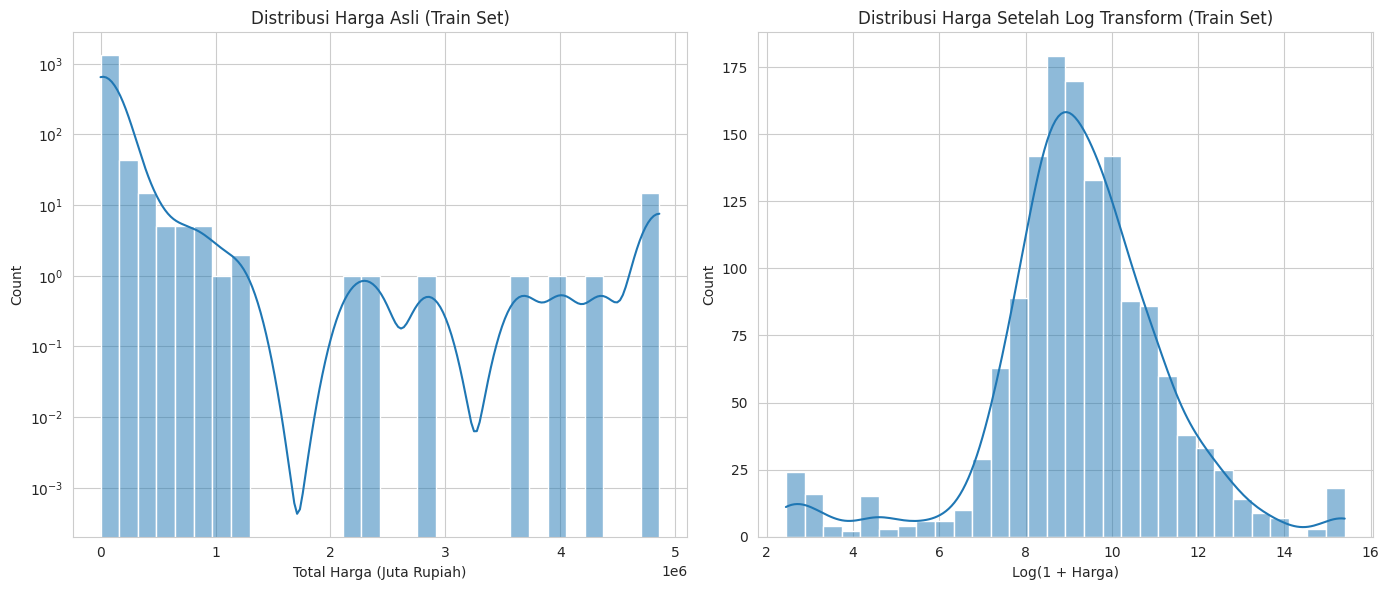


 Transformasi logaritmik selesai dan target disimpan kembali ke DataFrame

 Menghitung Price_per_meter_Juta dengan aman (setelah split)...
 Price per meter berhasil dihitung. Median: 20.00 juta/m²
Range price per meter (train): 0.00 - 33,000.00 juta/m²

 Transformasi log selesai dan data siap untuk feature engineering lanjutan


In [ ]:
# Cell 13: Transformasi Logaritmik (Hanya pada Train Set)
print(" Transformasi Logaritmik pada Target...")

# 1. Transformasi log pada target train
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# 2. Hitung skewness sebelum dan sesudah transformasi
original_skew = y_train.skew()
log_skew = y_train_log.skew()

print(f"\n Skewness sebelum transformasi: {original_skew:.2f}")
print(f" Skewness setelah transformasi log: {log_skew:.2f}")

# 3. Visualisasi perbandingan distribusi
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(y_train, bins=30, kde=True)
plt.title('Distribusi Harga Asli (Train Set)')
plt.xlabel('Total Harga (Juta Rupiah)')
plt.yscale('log')

plt.subplot(1, 2, 2)
sns.histplot(y_train_log, bins=30, kde=True)
plt.title('Distribusi Harga Setelah Log Transform (Train Set)')
plt.xlabel('Log(1 + Harga)')

plt.tight_layout()
plt.show()

# 4. Simpan target yang sudah ditransformasi
X_train['Log_Total_Price'] = y_train_log
X_test['Log_Total_Price'] = y_test_log

print("\n Transformasi logaritmik selesai dan target disimpan kembali ke DataFrame")

# 5. Hitung price per meter dengan aman (setelah split!)
#  PERBAIKAN: Gunakan y_train/y_test (target) bukan X_train['Total_Price_Juta']
print("\n Menghitung Price_per_meter_Juta dengan aman (setelah split)...")

X_train['Price_per_meter_Juta'] = y_train / X_train['Land_Area_m2']
X_test['Price_per_meter_Juta'] = y_test / X_test['Land_Area_m2']

# Handle infinite/NaN values
X_train['Price_per_meter_Juta'] = X_train['Price_per_meter_Juta'].replace([np.inf, -np.inf], np.nan)
X_test['Price_per_meter_Juta'] = X_test['Price_per_meter_Juta'].replace([np.inf, -np.inf], np.nan)

# Isi NaN dengan median dari train set
median_price_per_meter = X_train['Price_per_meter_Juta'].median()
X_train['Price_per_meter_Juta'] = X_train['Price_per_meter_Juta'].fillna(median_price_per_meter)
X_test['Price_per_meter_Juta'] = X_test['Price_per_meter_Juta'].fillna(median_price_per_meter)

# Transformasi log untuk price per meter
X_train['Log_Price_per_meter'] = np.log1p(X_train['Price_per_meter_Juta'])
X_test['Log_Price_per_meter'] = np.log1p(X_test['Price_per_meter_Juta'])

print(f" Price per meter berhasil dihitung. Median: {median_price_per_meter:,.2f} juta/m²")
print(f"Range price per meter (train): {X_train['Price_per_meter_Juta'].min():,.2f} - {X_train['Price_per_meter_Juta'].max():,.2f} juta/m²")

# Simpan median untuk deployment
with open('/content/drive/MyDrive/Rumah123_dataset/median_price_per_meter.pkl', 'wb') as f:
    pickle.dump(median_price_per_meter, f)

print("\n Transformasi log selesai dan data siap untuk feature engineering lanjutan")

In [ ]:
#Cell 14: Feature Engineering Basic (Hanya pada Train Set)

print(" Feature Engineering Dasar...")

# 1. Certificate Strength Mapping (sesuai dengan Cell 9 sebelumnya)
certificate_strength = {
    'SHM': 1.0,   # Sertifikat Hak Milik - paling kuat
    'HGB': 0.8,   # Hak Guna Bangunan
    'PPJB': 0.6,  # Perjanjian Pengikatan Jual Beli
    'Lainnya': 0.4 # Kategori lainnya
}

X_train['Certificate_Strength'] = X_train['Certificate_0'].map(certificate_strength)
X_test['Certificate_Strength'] = X_test['Certificate_0'].map(certificate_strength)

# Handle missing values
X_train['Certificate_Strength'] = X_train['Certificate_Strength'].fillna(0.4)  # Default ke kategori terlemah
X_test['Certificate_Strength'] = X_test['Certificate_Strength'].fillna(0.4)

print(" Certificate_Strength berhasil ditambahkan")

# 2. Area Size Categorization (berdasarkan train set)
print("\n Kategorisasi Ukuran Area...")

# Hitung kuantil dari train set
area_quantiles = X_train['Land_Area_m2'].quantile([0.25, 0.5, 0.75]).values
print(f"Kuantil untuk kategorisasi area: {area_quantiles}")

# Fungsi untuk mengkategorikan luas area
def categorize_area(area, quantiles):
    if area <= quantiles[0]:
        return 'Small'
    elif area <= quantiles[1]:
        return 'Medium'
    elif area <= quantiles[2]:
        return 'Large'
    else:
        return 'Extra Large'

# Terapkan ke train dan test set
X_train['Area_Category'] = X_train['Land_Area_m2'].apply(lambda x: categorize_area(x, area_quantiles))
X_test['Area_Category'] = X_test['Land_Area_m2'].apply(lambda x: categorize_area(x, area_quantiles))

# Tampilkan distribusi
print("\nDistribusi kategori area (train set):")
print(X_train['Area_Category'].value_counts(normalize=True).round(3))

# 3. Premium Area Indicator (berdasarkan daftar area premium yang ditentukan)
print("\n Identifikasi Area Premium...")

premium_areas = [
    'Menteng', 'Kebayoran Baru', 'Senopati', 'Pondok Indah', 'Puri Indah',
    'Kelapa Gading', 'Permata Hijau', 'Pulomas', 'Dharmawangsa',
    'Pantai Indah Kapuk', 'Pantai Indah Kapuk 2', 'Kembangan',
    'Sudirman', 'Dukuh Atas', 'Kemang', 'Setiabudi', 'SCBD',
    'Mangga Dua', 'Thamrin', 'Kuningan', 'Bendungan Hilir'
]

X_train['Is_Premium_Area'] = X_train['BreadcrumbList_ListItem_name_3'].isin(premium_areas).astype(int)
X_test['Is_Premium_Area'] = X_test['BreadcrumbList_ListItem_name_3'].isin(premium_areas).astype(int)

premium_train_pct = X_train['Is_Premium_Area'].mean() * 100
premium_test_pct = X_test['Is_Premium_Area'].mean() * 100

print(f"Persentase area premium (train): {premium_train_pct:.1f}%")
print(f"Persentase area premium (test): {premium_test_pct:.1f}%")

# Simpan daftar area premium untuk deployment
"""
with open('/content/drive/MyDrive/Rumah123_dataset/premium_areas.pkl', 'wb') as f:
    pickle.dump(premium_areas, f)
"""
print("\n Feature engineering dasar selesai")

 Feature Engineering Dasar...
 Certificate_Strength berhasil ditambahkan

 Kategorisasi Ukuran Area...
Kuantil untuk kategorisasi area: [ 250.   483.  1166.5]

Distribusi kategori area (train set):
Area_Category
Small          0.251
Extra Large    0.250
Large          0.250
Medium         0.249
Name: proportion, dtype: float64

 Identifikasi Area Premium...
Persentase area premium (train): 25.2%
Persentase area premium (test): 23.9%

 Feature engineering dasar selesai


In [ ]:
#Cell 15: Target Encoding untuk Lokasi (Hanya pada Train Set)
print(" Target Encoding untuk Lokasi...")

# 1. Buat temporary DataFrame untuk perhitungan
train_with_target = X_train.copy()
train_with_target['Log_Total_Price'] = y_train_log

# 2. Target encoding untuk wilayah Jakarta (BreadcrumbList_ListItem_name_2)
print("\n--- Target Encoding untuk Wilayah Jakarta ---")

# Hitung rata-rata log harga per wilayah dari train set
location_avg_price = train_with_target.groupby('BreadcrumbList_ListItem_name_2')['Log_Total_Price'].mean()
global_mean = y_train_log.mean()

# Smoothing untuk mengurangi overfitting pada area langka
# Formula: (n * mean_area + alpha * global_mean) / (n + alpha)
alpha = 5  # parameter smoothing
location_counts = train_with_target['BreadcrumbList_ListItem_name_2'].value_counts()

location_avg_smoothed = {}
for location in location_avg_price.index:
    n = location_counts.get(location, 0)
    mean_val = location_avg_price[location]
    smoothed_val = (n * mean_val + alpha * global_mean) / (n + alpha)
    location_avg_smoothed[location] = smoothed_val

# Tampilkan hasil
print("Rata-rata log harga per wilayah (setelah smoothing):")
for location, value in location_avg_smoothed.items():
    print(f"  {location}: {value:.4f}")

# Terapkan ke train dan test set
X_train['Location_Value'] = X_train['BreadcrumbList_ListItem_name_2'].map(location_avg_smoothed)
X_test['Location_Value'] = X_test['BreadcrumbList_ListItem_name_2'].map(location_avg_smoothed)

# Handle unseen categories di test set
unseen_locations = X_test['Location_Value'].isna()
if unseen_locations.any():
    print(f"\n  Ditemukan {unseen_locations.sum()} wilayah tidak dikenal di test set")
    X_test.loc[unseen_locations, 'Location_Value'] = global_mean

# 3. Target encoding untuk area spesifik (BreadcrumbList_ListItem_name_3)
print("\n--- Target Encoding untuk Area Spesifik ---")

# Hitung rata-rata log harga per area dari train set
area_avg_price = train_with_target.groupby('BreadcrumbList_ListItem_name_3')['Log_Total_Price'].mean()
area_counts = train_with_target['BreadcrumbList_ListItem_name_3'].value_counts()

area_avg_smoothed = {}
for area in area_avg_price.index:
    n = area_counts.get(area, 0)
    mean_val = area_avg_price[area]
    smoothed_val = (n * mean_val + alpha * global_mean) / (n + alpha)
    area_avg_smoothed[area] = smoothed_val

# Tampilkan top 10 area termahal
top_10_areas = sorted(area_avg_smoothed.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 area termahal (berdasarkan log harga rata-rata):")
for i, (area, value) in enumerate(top_10_areas, 1):
    print(f"  {i}. {area}: {value:.4f}")

# Terapkan ke train dan test set
X_train['Area_Value'] = X_train['BreadcrumbList_ListItem_name_3'].map(area_avg_smoothed)
X_test['Area_Value'] = X_test['BreadcrumbList_ListItem_name_3'].map(area_avg_smoothed)

# Handle unseen categories di test set
unseen_areas = X_test['Area_Value'].isna()
if unseen_areas.any():
    print(f"\n  Ditemukan {unseen_areas.sum()} area tidak dikenal di test set")
    X_test.loc[unseen_areas, 'Area_Value'] = global_mean

# 4. Simpan mapping untuk interpretasi dan deployment
print("\n Menyimpan mapping lokasi untuk interpretasi...")

location_mapping = {
    'location_avg_price': location_avg_smoothed,
    'area_avg_price': area_avg_smoothed,
    'global_mean': global_mean,
    'alpha': alpha,
    'premium_areas': premium_areas
}
"""
with open('/content/drive/MyDrive/Rumah123_dataset/location_mapping.pkl', 'wb') as f:
    pickle.dump(location_mapping, f)
"""
print(" Mapping lokasi berhasil disimpan")

print("\n Target encoding untuk lokasi selesai")

 Target Encoding untuk Lokasi...

--- Target Encoding untuk Wilayah Jakarta ---
Rata-rata log harga per wilayah (setelah smoothing):
  Jakarta Barat: 8.9915
  Jakarta Pusat: 10.1729
  Jakarta Selatan: 9.5611
  Jakarta Timur: 8.1976
  Jakarta Utara: 9.6143

--- Target Encoding untuk Area Spesifik ---

Top 10 area termahal (berdasarkan log harga rata-rata):
  1. Menteng: 10.8636
  2. Daan Mogot: 10.7111
  3. Mega Kuningan: 10.5344
  4. Kebagusan: 10.3864
  5. Senen: 10.3514
  6. S Parman: 10.2951
  7. Sudirman: 10.2796
  8. Marunda: 10.1514
  9. Pangeran Jayakarta: 10.1345
  10. Radio Dalam: 10.1336

  Ditemukan 15 area tidak dikenal di test set

 Menyimpan mapping lokasi untuk interpretasi...
 Mapping lokasi berhasil disimpan

 Target encoding untuk lokasi selesai


In [ ]:
print("\n21 Area tidak dikenal di test set:")
# Pastikan X_test_raw dan unseen_areas tersedia dari eksekusi Cell 15
if 'unseen_areas' in globals() and 'X_test_raw' in globals():
    unseen_specific_areas = X_test_raw.loc[unseen_areas, 'BreadcrumbList_ListItem_name_3'].unique()
    if len(unseen_specific_areas) > 0:
        for i, area in enumerate(unseen_specific_areas):
            print(f"  {i+1}. {area}")
    else:
        print("Tidak ada area tidak dikenal yang ditemukan.")
else:
    print("Variabel 'unseen_areas' atau 'X_test_raw' tidak tersedia. Pastikan Cell 15 telah dieksekusi.")


21 Area tidak dikenal di test set:
  1. Guntur
  2. Muara Karang
  3. Utan Kayu
  4. Raffles Hills
  5. Sektor 1 - Bintaro
  6. Pejaten Timur
  7. Karang Anyar
  8. Lubang Buaya
  9. Cipulir
  10. Gudang Peluru
  11. Kapten Tendean
  12. Metland Menteng
  13. Roxy
  14. Bojong Indah


In [ ]:
#Cell 16: Frequency Encoding untuk Area (Hanya pada Train Set)
print(" Frequency Encoding untuk Area Spesifik...")

# 1. Hitung frekuensi setiap area di train set
area_frequency = X_train['BreadcrumbList_ListItem_name_3'].value_counts()
total_train = len(X_train)

# Tampilkan top 10 area paling umum
print("\nTop 10 area paling umum di train set:")
for area, count in area_frequency.head(10).items():
    print(f"  {area}: {count} ({count/total_train:.1%})")

# 2. Hitung frekuensi relatif (proporsi)
area_frequency_relative = area_frequency / total_train

# 3. Terapkan ke train dan test set
X_train['Area_Frequency'] = X_train['BreadcrumbList_ListItem_name_3'].map(area_frequency_relative)
X_test['Area_Frequency'] = X_test['BreadcrumbList_ListItem_name_3'].map(area_frequency_relative)

# 4. Handle unseen categories di test set
unseen_areas = X_test['Area_Frequency'].isna()
if unseen_areas.any():
    print(f"\n  Ditemukan {unseen_areas.sum()} area tidak dikenal di test set")
    # Untuk area baru, gunakan frekuensi minimum yang diamati
    min_frequency = area_frequency_relative.min()
    X_test.loc[unseen_areas, 'Area_Frequency'] = min_frequency

# 5. Tambahkan fitur baru: Price_to_Location_Ratio (dengan aman!)
print("\n Menghitung Price_to_Location_Ratio...")

# Hanya menggunakan informasi dari train set
X_train['Price_to_Location_Ratio'] = X_train['Log_Price_per_meter'] / X_train['Location_Value']
X_test['Price_to_Location_Ratio'] = X_test['Log_Price_per_meter'] / X_test['Location_Value']

# Handle infinite/NaN values
X_train['Price_to_Location_Ratio'] = X_train['Price_to_Location_Ratio'].replace([np.inf, -np.inf], np.nan)
X_test['Price_to_Location_Ratio'] = X_test['Price_to_Location_Ratio'].replace([np.inf, -np.inf], np.nan)

# Isi NaN dengan median dari train set
median_ratio = X_train['Price_to_Location_Ratio'].median()
X_train['Price_to_Location_Ratio'] = X_train['Price_to_Location_Ratio'].fillna(median_ratio)
X_test['Price_to_Location_Ratio'] = X_test['Price_to_Location_Ratio'].fillna(median_ratio)

print(f" Price_to_Location_Ratio berhasil dihitung. Median: {median_ratio:.4f}")

# 6. Simpan frekuensi area untuk deployment
area_freq_mapping = {
    'area_frequency': area_frequency_relative.to_dict(),
    'min_frequency': min_frequency,
    'median_ratio': median_ratio
}
"""
with open('/content/drive/MyDrive/Rumah123_dataset/area_frequency_mapping.pkl', 'wb') as f:
    pickle.dump(area_freq_mapping, f)
"""
print("\n Frequency encoding untuk area selesai")

 Frequency Encoding untuk Area Spesifik...

Top 10 area paling umum di train set:
  Pantai Indah Kapuk: 128 (9.0%)
  Menteng: 65 (4.6%)
  Duren Sawit: 47 (3.3%)
  Cakung: 44 (3.1%)
  Kelapa Gading: 37 (2.6%)
  Pulo Gadung: 35 (2.5%)
  Cilandak: 32 (2.3%)
  Cempaka Putih: 27 (1.9%)
  Senen: 27 (1.9%)
  Ciracas: 26 (1.8%)

  Ditemukan 15 area tidak dikenal di test set

 Menghitung Price_to_Location_Ratio...
 Price_to_Location_Ratio berhasil dihitung. Median: 0.3279

 Frequency encoding untuk area selesai


In [ ]:
#Cell 17: One-Hot Encoding untuk Wilayah (Aman karena tidak mengandung target)

print("  One-Hot Encoding untuk Wilayah Jakarta...")

# 1. Siapkan data
train_wilayah = X_train[['BreadcrumbList_ListItem_name_2']].copy()
test_wilayah = X_test[['BreadcrumbList_ListItem_name_2']].copy()

# 2. Buat encoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first untuk menghindari multicollinearity

# 3. Fit pada train set dan transform
wilayah_encoded_train = encoder.fit_transform(train_wilayah)
wilayah_encoded_test = encoder.transform(test_wilayah)

# 4. Buat nama kolom yang informatif
wilayah_categories = encoder.categories_[0][1:]  # Skip kategori pertama yang di-drop
wilayah_columns = [f'wilayah_{cat.replace(" ", "_")}' for cat in wilayah_categories]

print(f" One-hot encoding untuk {len(wilayah_columns)} wilayah:")
for col in wilayah_columns:
    print(f"  - {col}")

# 5. Buat DataFrame dari hasil encoding
train_wilayah_encoded = pd.DataFrame(wilayah_encoded_train, columns=wilayah_columns, index=X_train.index)
test_wilayah_encoded = pd.DataFrame(wilayah_encoded_test, columns=wilayah_columns, index=X_test.index)

# 6. Gabungkan ke dataset utama
X_train = pd.concat([X_train, train_wilayah_encoded], axis=1)
X_test = pd.concat([X_test, test_wilayah_encoded], axis=1)
"""
# 7. Simpan encoder untuk deployment
with open('/content/drive/MyDrive/Rumah123_dataset/wilayah_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)
"""
print("\n One-hot encoding untuk wilayah Jakarta selesai")

  One-Hot Encoding untuk Wilayah Jakarta...
 One-hot encoding untuk 4 wilayah:
  - wilayah_Jakarta_Pusat
  - wilayah_Jakarta_Selatan
  - wilayah_Jakarta_Timur
  - wilayah_Jakarta_Utara

 One-hot encoding untuk wilayah Jakarta selesai


In [ ]:
#Cell 18: Advanced Feature Engineering (Hanya pada Train Set)
print(" Advanced Feature Engineering...")
# 2. Binning untuk fitur numerik
print("\n Membuat Binned Features...")

# a. Harga per meter kategori
price_per_meter_bins = X_train['Price_per_meter_Juta'].quantile([0.25, 0.5, 0.75]).values
X_train['Price_per_meter_Category'] = pd.cut(
    X_train['Price_per_meter_Juta'],
    bins=[-np.inf] + list(price_per_meter_bins) + [np.inf],
    labels=['Murah', 'Sedang', 'Mahal', 'Sangat Mahal']
)

X_test['Price_per_meter_Category'] = pd.cut(
    X_test['Price_per_meter_Juta'],
    bins=[-np.inf] + list(price_per_meter_bins) + [np.inf],
    labels=['Murah', 'Sedang', 'Mahal', 'Sangat Mahal']
)

# b. Lokasi value kategori
location_value_bins = X_train['Location_Value'].quantile([0.33, 0.66]).values
X_train['Location_Value_Category'] = pd.cut(
    X_train['Location_Value'],
    bins=[-np.inf] + list(location_value_bins) + [np.inf],
    labels=['Lokasi_Rendah', 'Lokasi_Sedang', 'Lokasi_Tinggi']
)

X_test['Location_Value_Category'] = pd.cut(
    X_test['Location_Value'],
    bins=[-np.inf] + list(location_value_bins) + [np.inf],
    labels=['Lokasi_Rendah', 'Lokasi_Sedang', 'Lokasi_Tinggi']
)

print(" Binned features berhasil dibuat")

# 3. Simpan batas binning untuk deployment
binning_params = {
    'price_per_meter_bins': price_per_meter_bins,
    'location_value_bins': location_value_bins
}
"""
with open('/content/drive/MyDrive/Rumah123_dataset/binning_params.pkl', 'wb') as f:
    pickle.dump(binning_params, f)
"""
print("\n Advanced feature engineering selesai")

 Advanced Feature Engineering...

 Membuat Binned Features...
 Binned features berhasil dibuat

 Advanced feature engineering selesai


In [ ]:
#Cell 19: Scaling (Hanya Fit pada Train Set)
print(" Scaling Numerical Features...")

# 1. Identifikasi kolom numerik yang perlu di-scaling
numerical_columns = [
    'Land_Area_m2',
    'Certificate_Strength',
    'Location_Value',
    'Area_Value',
    'Area_Frequency',
    'Log_Price_per_meter',
    'Price_to_Location_Ratio',
    'Area_Cert_Interaction',
    'Area_Location_Interaction',
    'Premium_Location_Interaction'
]

# Filter hanya kolom yang benar-benar ada di dataset
numerical_columns = [col for col in numerical_columns if col in X_train.columns]
print(f"\nKolom numerik yang akan di-scaling ({len(numerical_columns)}):")
for col in numerical_columns:
    print(f"  - {col}")

# 2. Buat salinan untuk data yang di-scaling
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# 3. Inisialisasi dan fit scaler pada train set
scaler = StandardScaler()
X_train_scaled[numerical_columns] = scaler.fit_transform(X_train_scaled[numerical_columns])

# 4. Transform test set dengan parameter dari train set
X_test_scaled[numerical_columns] = scaler.transform(X_test_scaled[numerical_columns])

# 5. Verifikasi hasil scaling
print("\n Statistik setelah scaling (Train Set):")
for col in numerical_columns:
    print(f"  {col}: mean={X_train_scaled[col].mean():.4f}, std={X_train_scaled[col].std():.4f}")

print("\n Statistik setelah scaling (Test Set):")
for col in numerical_columns:
    print(f"  {col}: mean={X_test_scaled[col].mean():.4f}, std={X_test_scaled[col].std():.4f}")
"""
# 6. Simpan scaler untuk deployment
with open('/content/drive/MyDrive/Rumah123_dataset/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
"""
print("\n Scaling selesai dan scaler berhasil disimpan")

 Scaling Numerical Features...

Kolom numerik yang akan di-scaling (7):
  - Land_Area_m2
  - Certificate_Strength
  - Location_Value
  - Area_Value
  - Area_Frequency
  - Log_Price_per_meter
  - Price_to_Location_Ratio

 Statistik setelah scaling (Train Set):
  Land_Area_m2: mean=-0.0000, std=1.0004
  Certificate_Strength: mean=0.0000, std=1.0004
  Location_Value: mean=0.0000, std=1.0004
  Area_Value: mean=0.0000, std=1.0004
  Area_Frequency: mean=0.0000, std=1.0004
  Log_Price_per_meter: mean=0.0000, std=1.0004
  Price_to_Location_Ratio: mean=-0.0000, std=1.0004

 Statistik setelah scaling (Test Set):
  Land_Area_m2: mean=-0.1334, std=0.0977
  Certificate_Strength: mean=-0.1265, std=1.0367
  Location_Value: mean=0.0034, std=1.0012
  Area_Value: mean=-0.0870, std=0.9695
  Area_Frequency: mean=-0.0171, std=1.0399
  Log_Price_per_meter: mean=0.0035, std=0.7857
  Price_to_Location_Ratio: mean=0.0161, std=0.8087

 Scaling selesai dan scaler berhasil disimpan


 Final Feature Selection dan Validasi...

Total fitur yang tersedia: 27

Fitur yang akan digunakan untuk modeling (11):
  1. Location_Value
  2. Area_Value
  3. Area_Frequency
  4. Is_Premium_Area
  5. Land_Area_m2
  6. Certificate_Strength
  7. wilayah_Jakarta_Pusat
  8. wilayah_Jakarta_Selatan
  9. wilayah_Jakarta_Timur
  10. wilayah_Jakarta_Utara
  11. Log_Total_Price

 Validasi Data Leakage...
 Tidak ditemukan fitur yang mengandung target (tidak ada leakage)

 Matriks Korelasi Fitur...


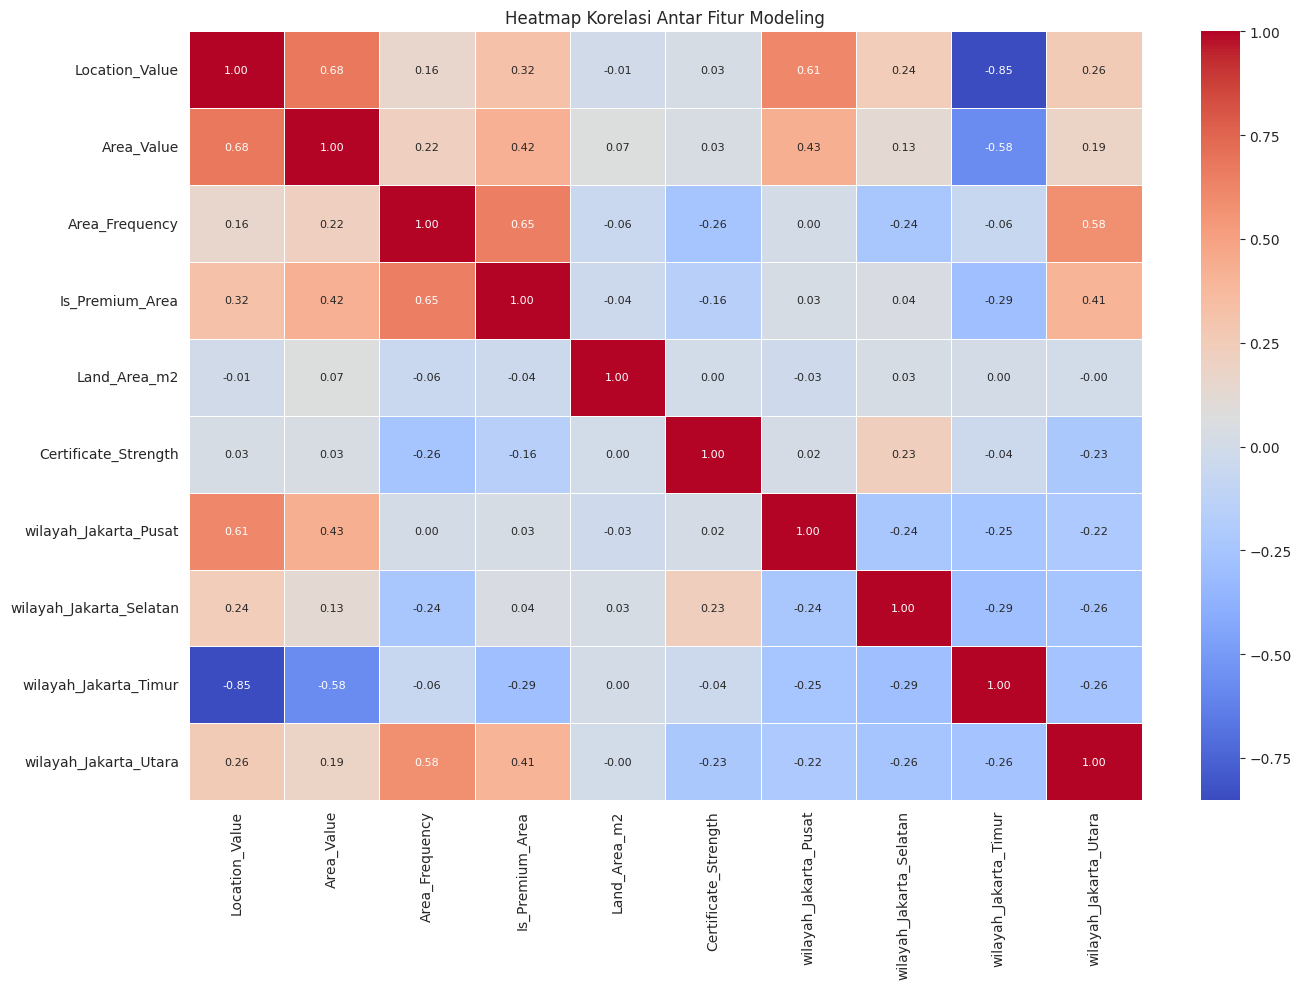


  Ditemukan 1 pasang fitur highly correlated (>0.8):
  - wilayah_Jakarta_Timur dan Location_Value: korelasi = -0.852

 Menyimpan Dataset Final...

Dataset 'final_dataset' berhasil disimpan dengan 1773 baris dan 11 kolom.

 Dataset final berhasil disimpan

 RINGKASAN AKHIR PIPELINE
Dimensi train set final: (1418, 10)
Dimensi test set final: (355, 10)
Jumlah fitur: 10
Target: Log_Total_Price (log(1 + Total_Price_Juta))

 DATA SIAP UNTUK MODELING!


In [ ]:
#Cell 20: Final Feature Selection dan Validasi
print(" Final Feature Selection dan Validasi...")

# 1. Siapkan daftar semua fitur yang tersedia
all_features = X_train_scaled.columns.tolist()
print(f"\nTotal fitur yang tersedia: {len(all_features)}")

# 2. Daftar fitur yang akan digunakan untuk modeling
feature_columns_final = [
    # Fitur lokasi
    'Location_Value',
    'Area_Value',
    'Area_Frequency',
    'Is_Premium_Area',
    #'Price_to_Location_Ratio', # Ini adalah fitur yang berpotensi leaking

    # Fitur numerik dasar
    'Land_Area_m2',
    'Certificate_Strength',
    #'Log_Price_per_meter', # INI ADALAH FITUR LEAKAGE - HARUS DIHAPUS

    # One-hot encoding wilayah
    'wilayah_Jakarta_Pusat',
    'wilayah_Jakarta_Selatan',
    'wilayah_Jakarta_Timur',
    'wilayah_Jakarta_Utara',

    # Target (untuk referensi)
    'Log_Total_Price' # Ini akan di-drop sebelum training model
]

# Filter hanya fitur yang benar-benar ada
feature_columns_final = [col for col in feature_columns_final if col in X_train_scaled.columns]
print(f"\nFitur yang akan digunakan untuk modeling ({len(feature_columns_final)}):")
for i, col in enumerate(feature_columns_final, 1):
    print(f"  {i}. {col}")

# 3. Buat dataset akhir untuk modeling
X_train_final = X_train_scaled[feature_columns_final].drop(columns=['Log_Total_Price'])
X_test_final = X_test_scaled[feature_columns_final].drop(columns=['Log_Total_Price'])
y_train_final = X_train_scaled['Log_Total_Price']
y_test_final = X_test_scaled['Log_Total_Price']

# 4. Validasi tidak ada leakage
print("\n Validasi Data Leakage...")
leakage_features = ['Price_per_meter_Juta', 'Total_Price_Juta', 'Log_Price_per_meter']  # Tambahkan Log_Price_per_meter ke daftar cek
leakage_detected = False

for feature in leakage_features:
    if feature in X_train_final.columns:
        print(f"  POTENTIAL LEAKAGE: '{feature}' ditemukan dalam fitur modeling!")
        leakage_detected = True

if not leakage_detected:
    print(" Tidak ditemukan fitur yang mengandung target (tidak ada leakage)")

# 5. Cek korelasi fitur
print("\n Matriks Korelasi Fitur...")
correlation_matrix = X_train_final.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5,
            annot_kws={'size': 8})
plt.title('Heatmap Korelasi Antar Fitur Modeling')
plt.tight_layout()
plt.show()

# 6. Identifikasi fitur highly correlated
high_corr_threshold = 0.8
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            high_corr_pairs.append((colname1, colname2, correlation_matrix.iloc[i, j]))

if high_corr_pairs:
    print(f"\n  Ditemukan {len(high_corr_pairs)} pasang fitur highly correlated (>{high_corr_threshold}):")
    for col1, col2, corr in high_corr_pairs:
        print(f"  - {col1} dan {col2}: korelasi = {corr:.3f}")
else:
    print("\n Tidak ditemukan fitur highly correlated")

# 7. Simpan dataset final
print("\n Menyimpan Dataset Final...")

# Gabungkan X dan y untuk train dan test set
train_final = pd.concat([X_train_final, y_train_final], axis=1)
test_final = pd.concat([X_test_final, y_test_final], axis=1)

# Simpan ke file
#train_final.to_csv('/content/drive/MyDrive/Rumah123_dataset/train_final.csv', index=False)
#test_final.to_csv('/content/drive/MyDrive/Rumah123_dataset/test_final.csv', index=False)

# Gabungkan kembali train_final dan test_final menjadi satu dataset utuh
final_dataset = pd.concat([train_final, test_final], ignore_index=True)

# Simpan final_dataset ke CSV
final_dataset.to_csv('/content/drive/MyDrive/Rumah123_dataset/final_dataset.csv', index=False)

# Hitung baris dan kolom pada final_dataset
print(f"\nDataset 'final_dataset' berhasil disimpan dengan {final_dataset.shape[0]} baris dan {final_dataset.shape[1]} kolom.")

# Simpan daftar fitur
with open('/content/drive/MyDrive/Rumah123_dataset/feature_names.txt', 'w') as f:
    f.write(','.join(X_train_final.columns.tolist()))

# Simpan Data Final Utuh dibawah sini
print("\n Dataset final berhasil disimpan")

# 8. Ringkasan akhir
print("\n RINGKASAN AKHIR PIPELINE")
print(f"Dimensi train set final: {X_train_final.shape}")
print(f"Dimensi test set final: {X_test_final.shape}")
print(f"Jumlah fitur: {X_train_final.shape[1]}")
print(f"Target: Log_Total_Price (log(1 + Total_Price_Juta))")

print("\n DATA SIAP UNTUK MODELING!")

# **Explorasi Data Analytics (EDA)**


Descriptive Statistics for Numerical Features:


,Total_Price_Juta,Land_Area_m2,Certificate_Strength,Log_Total_Price,Price_per_meter_Juta
count,1.773000e+03,1773.000000,1773.000000,1773.000000,1773.000000
mean,3.006078e+05,2564.350818,0.813311,9.274625,313.123041
std,3.152801e+06,11493.527480,0.244956,2.094390,3210.578278
min,2.800000e+00,1.000000,0.400000,1.335001,0.000750
25%,4.100000e+03,257.000000,0.600000,8.318986,11.782178
50%,1.010000e+04,484.000000,1.000000,9.220390,20.000000
75%,3.100000e+04,1156.000000,1.000000,10.341775,29.906542
max,6.560000e+07,250000.000000,1.000000,17.999086,76397.515528



Value Counts for Categorical Features:

--- BreadcrumbList_ListItem_name_2 ---


,count
BreadcrumbList_ListItem_name_2,
Jakarta Timur,406
Jakarta Selatan,395
Jakarta Barat,335
Jakarta Utara,334
Jakarta Pusat,303



--- BreadcrumbList_ListItem_name_3 ---


,count
BreadcrumbList_ListItem_name_3,
Pantai Indah Kapuk,163
Menteng,75
Duren Sawit,63
Cakung,60
Kelapa Gading,42
...,...
Jatiwaringin,1
Otista,1
Buaran,1



--- Certificate_0 ---


,count
Certificate_0,
SHM,1009
Lainnya,383
HGB,256
PPJB,125



Visualizing Target Variable Distribution...


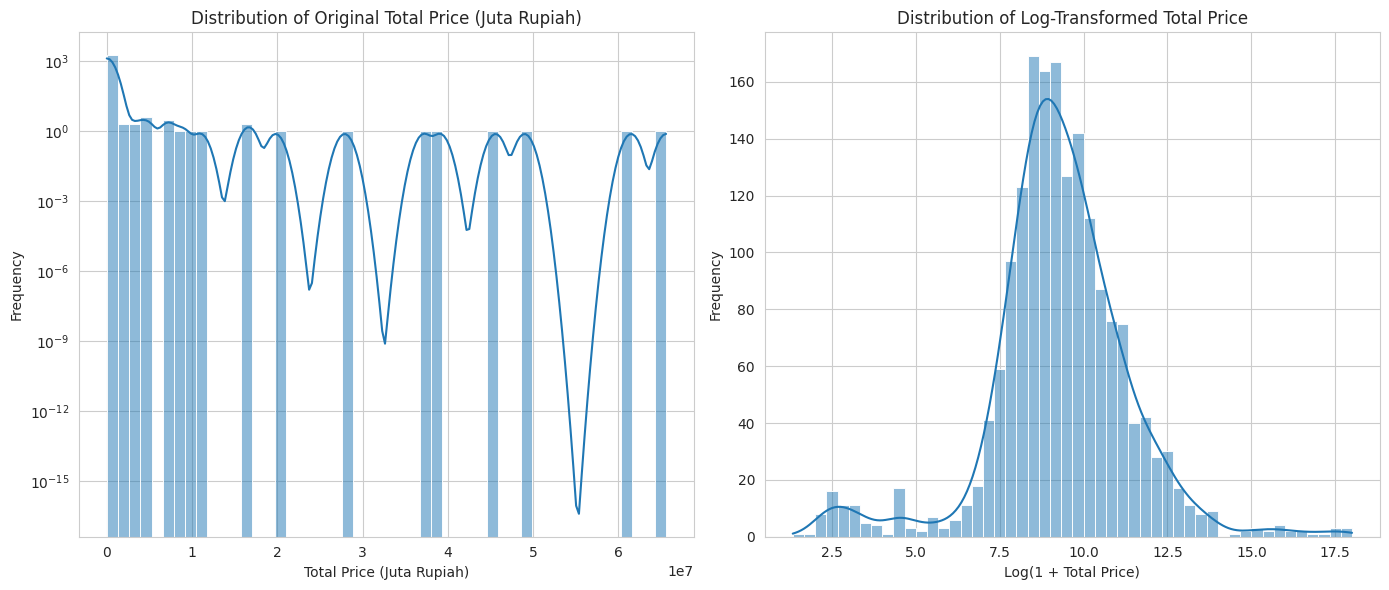

Target variable distribution visualizations complete.

Visualizing Numerical Features Distribution (Histograms and Box Plots)...


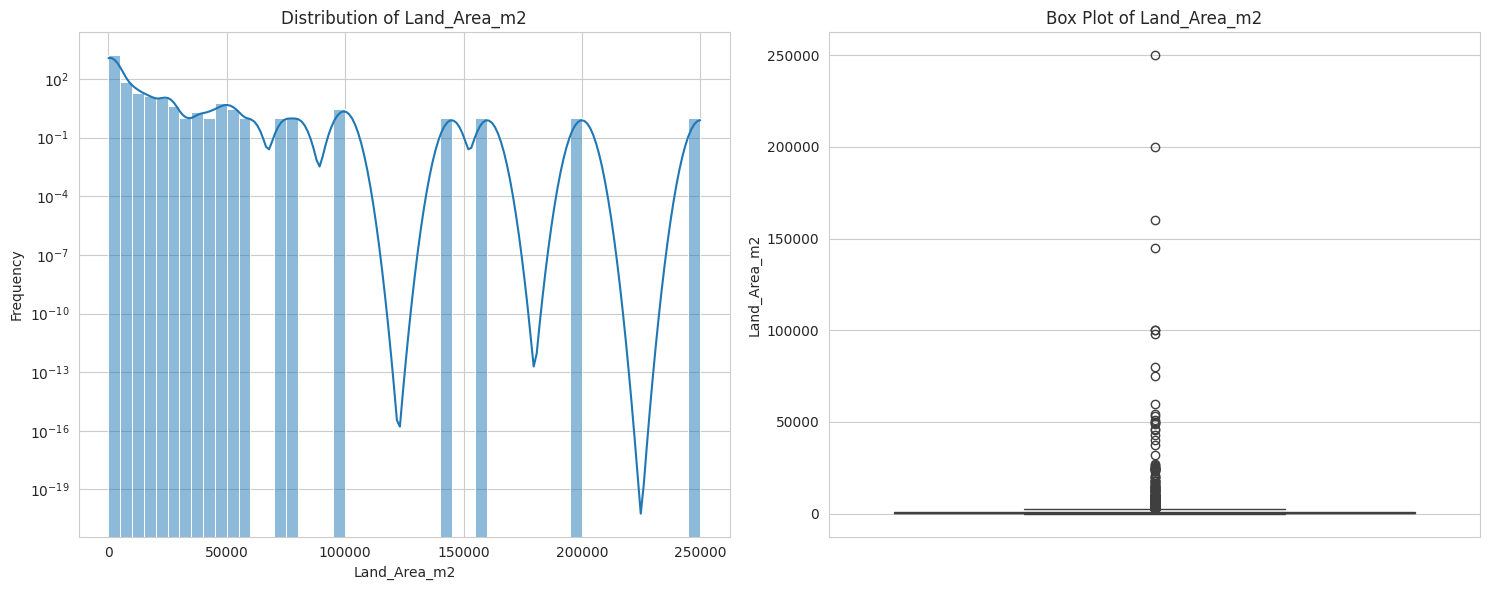

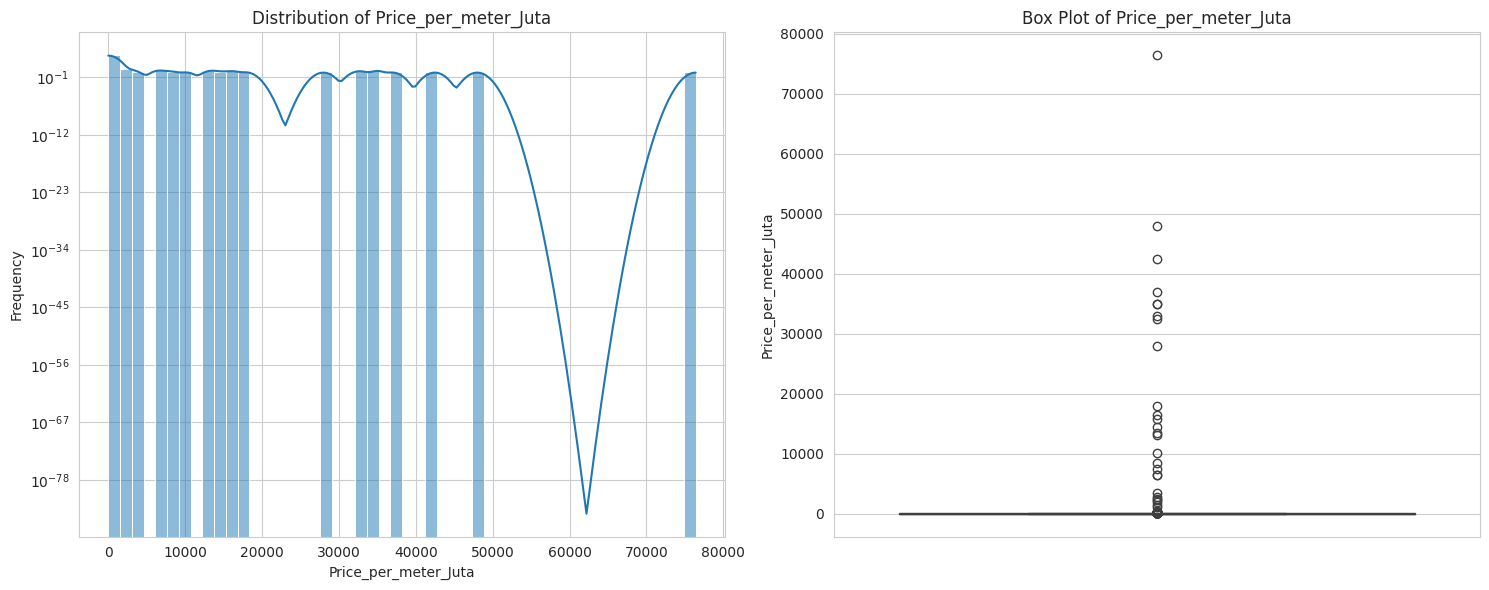

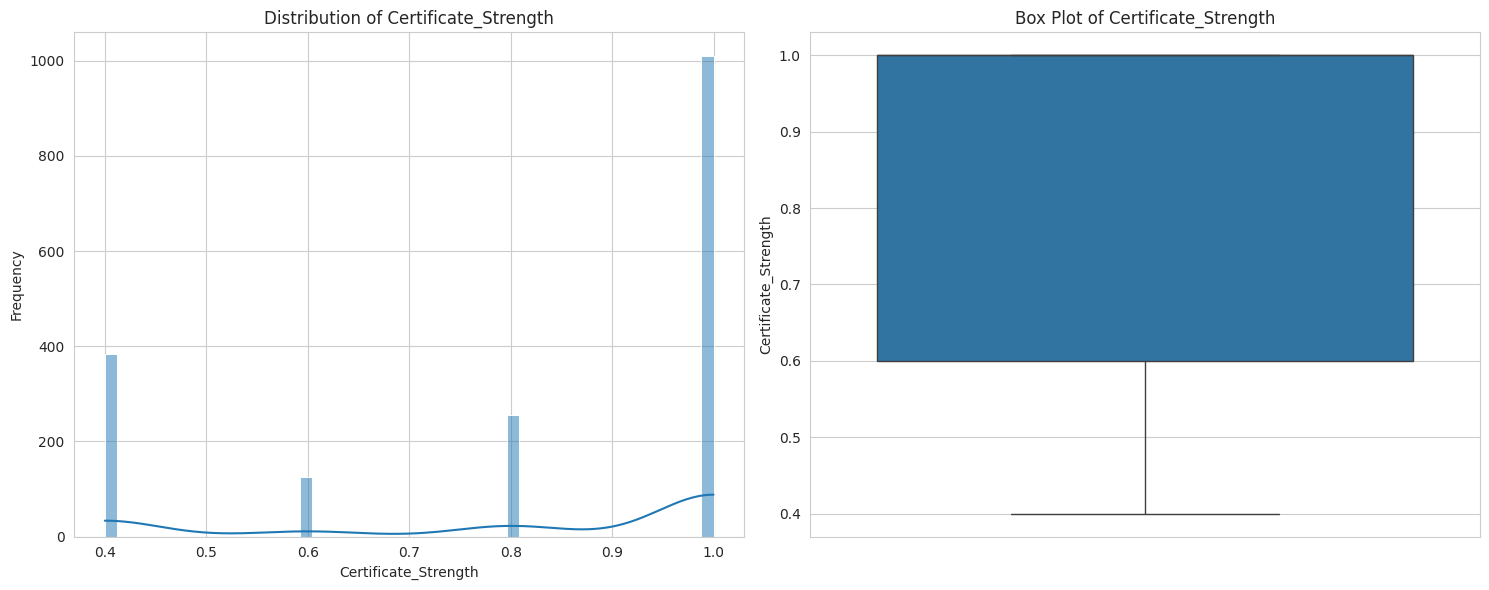

Numerical features distribution visualizations complete.

Visualizing Categorical Features Distribution (Count Plots)...


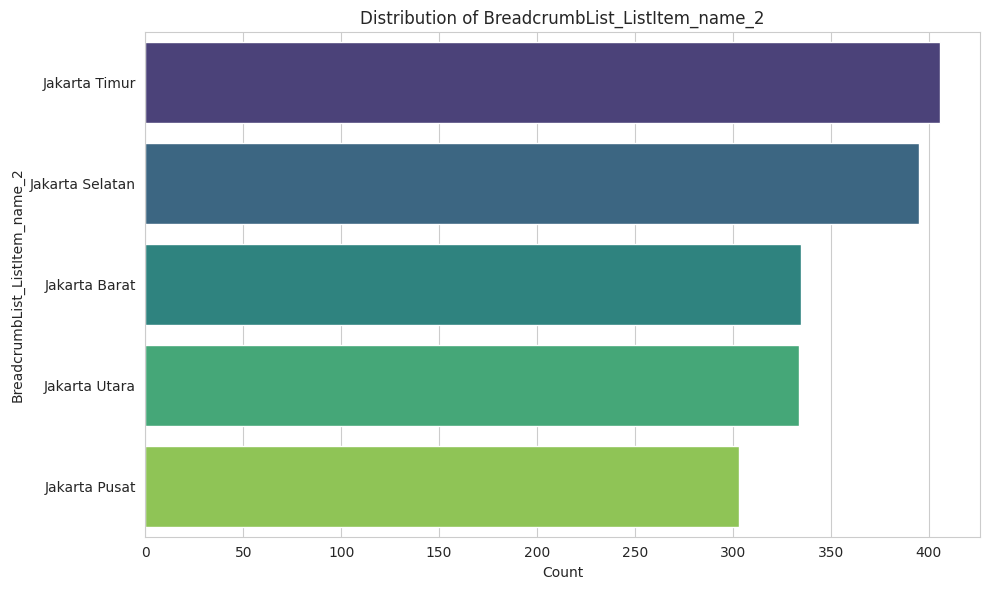

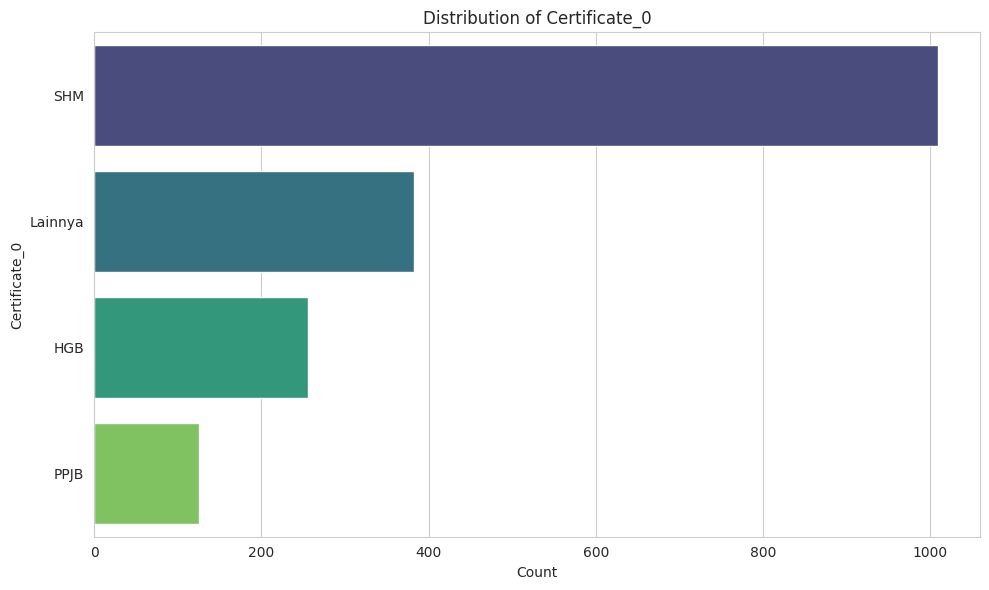

Categorical features distribution visualizations complete.

Visualizing Relationship between Categorical Features and Target (Log_Total_Price)...


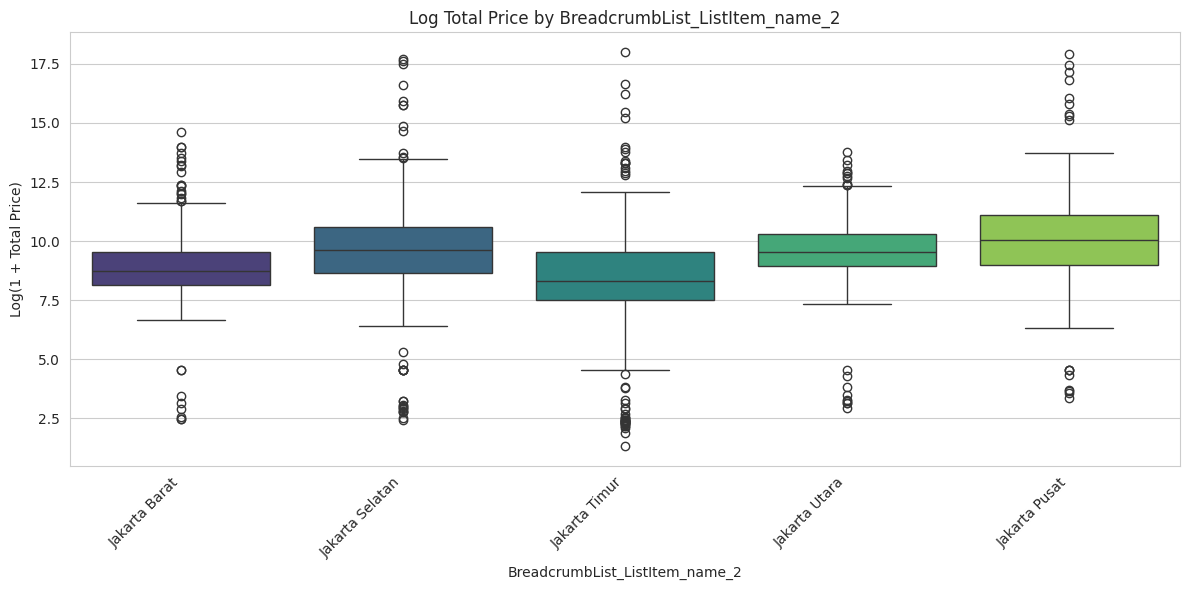

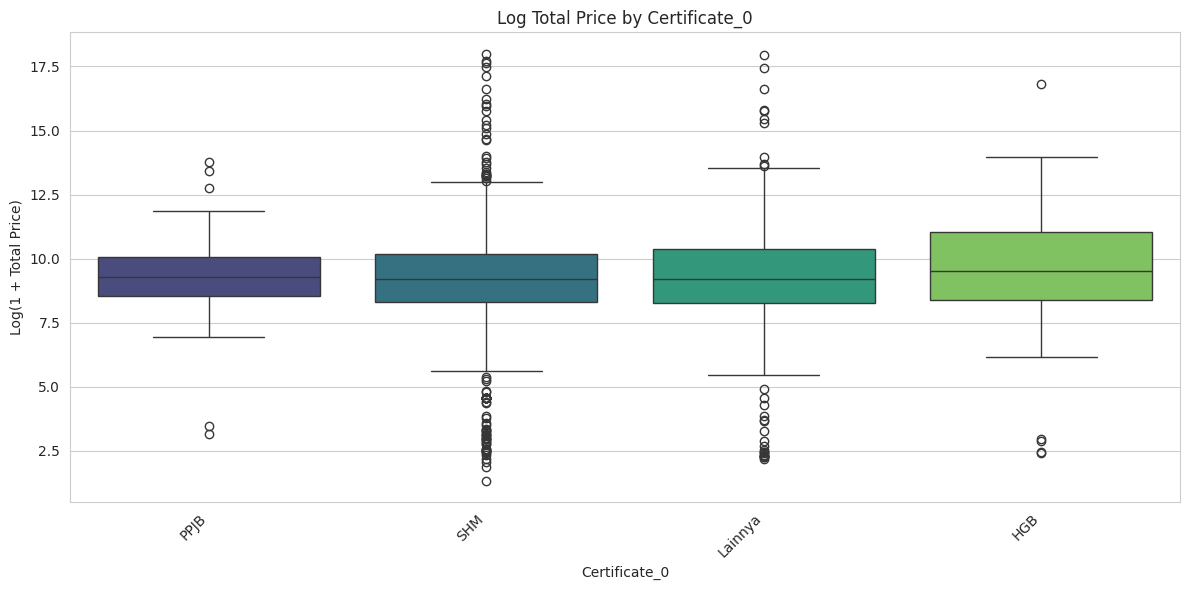

Relationship between categorical features and target visualizations complete.

Visualizing Relationship between Numerical Features and Target (Log_Total_Price)...



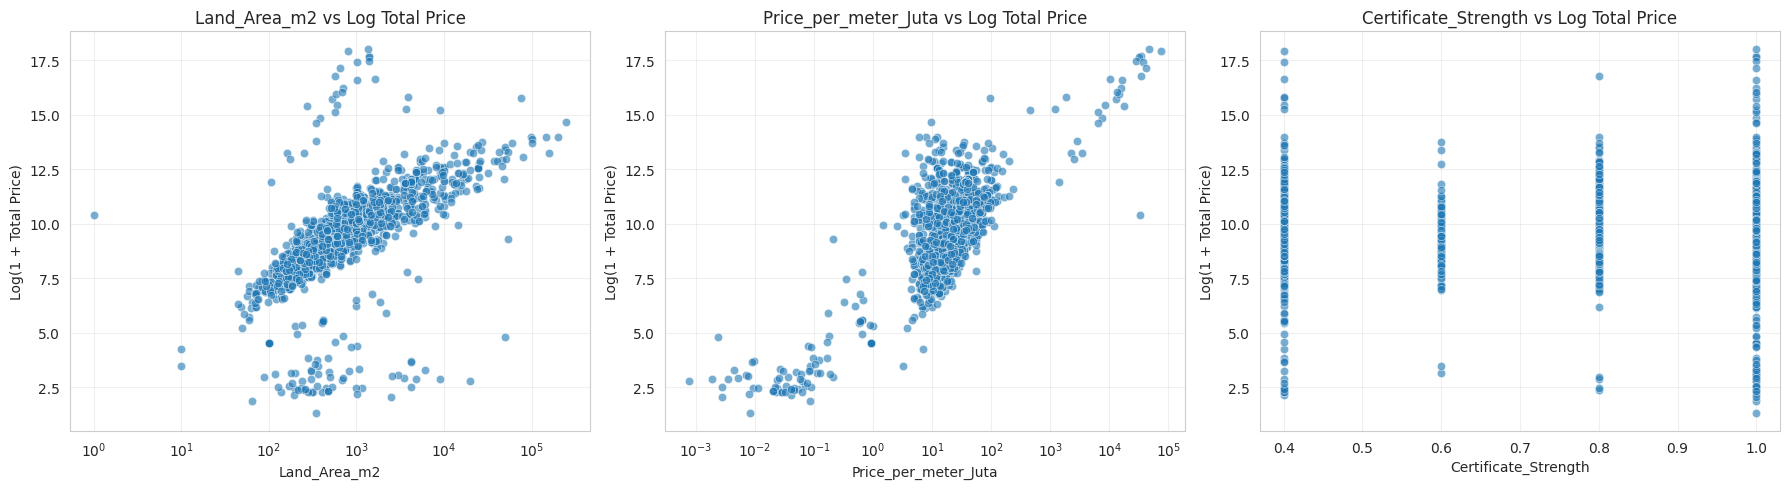

Relationship between numerical features and target visualizations complete.

Generating Correlation Heatmap...

 Matriks Korelasi Fitur...


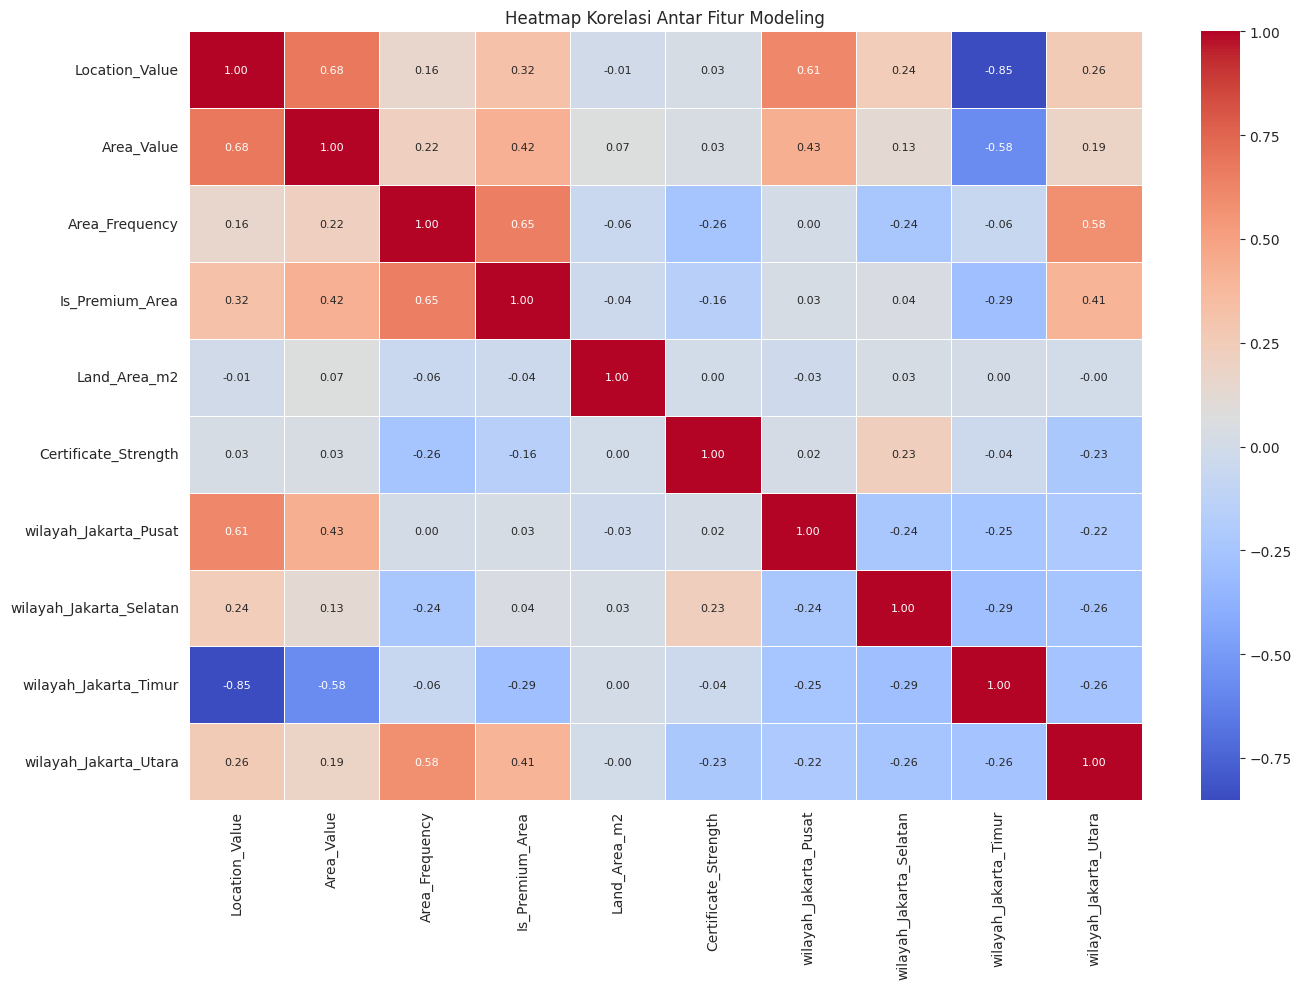

Correlation heatmap generation complete.


In [ ]:
# 1. Descriptive Statistics for Numerical Features
print("\nDescriptive Statistics for Numerical Features:")
numerical_cols = ['Total_Price_Juta', 'Land_Area_m2', 'Certificate_Strength']
# Log_Total_Price and Price_per_meter_Juta will be created later if not already present
# For EDA, we might want to calculate them on eda_df if not already done.
# Assuming these columns are already generated from previous steps if not then the script will fail
# As per the prompt, these columns are expected to be available or will be created.

# Check if Log_Total_Price and Price_per_meter_Juta exist, if not, create them for EDA
if 'Log_Total_Price' not in preprocessed_df.columns:
    preprocessed_df['Log_Total_Price'] = np.log1p(preprocessed_df['Total_Price_Juta'])
if 'Price_per_meter_Juta' not in preprocessed_df.columns:
    # Recalculate based on original price and area for consistency in EDA
    preprocessed_df['Price_per_meter_Juta'] = preprocessed_df['Total_Price_Juta'] / preprocessed_df['Land_Area_m2']
    # Fill inf/NaN with median for this specific EDA context, similar to how it was handled before
    preprocessed_df['Price_per_meter_Juta'] = preprocessed_df['Price_per_meter_Juta'].replace([np.inf, -np.inf], np.nan)
    preprocessed_df['Price_per_meter_Juta'] = preprocessed_df['Price_per_meter_Juta'].fillna(preprocessed_df['Price_per_meter_Juta'].median())

numerical_cols.extend(['Log_Total_Price', 'Price_per_meter_Juta'])

display(preprocessed_df[numerical_cols].describe())

# 2. Value Counts for Categorical Features
print("\nValue Counts for Categorical Features:")
categorical_cols = ['BreadcrumbList_ListItem_name_2', 'BreadcrumbList_ListItem_name_3', 'Certificate_0']
for col in categorical_cols:
    print(f"\n--- {col} ---")
    display(preprocessed_df[col].value_counts())


print("\nVisualizing Target Variable Distribution...")

plt.figure(figsize=(14, 6))

# Distribution of original Total_Price_Juta
plt.subplot(1, 2, 1)
sns.histplot(preprocessed_df['Total_Price_Juta'], bins=50, kde=True)
plt.title('Distribution of Original Total Price (Juta Rupiah)')
plt.xlabel('Total Price (Juta Rupiah)')
plt.ylabel('Frequency')
plt.yscale('log') # Use log scale for y-axis due to wide range of prices

# Distribution of Log_Total_Price
plt.subplot(1, 2, 2)
sns.histplot(preprocessed_df['Log_Total_Price'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Total Price')
plt.xlabel('Log(1 + Total Price)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Target variable distribution visualizations complete.")
print("\nVisualizing Numerical Features Distribution (Histograms and Box Plots)...")

numerical_features_eda = ['Land_Area_m2', 'Price_per_meter_Juta', 'Certificate_Strength']

for feature in numerical_features_eda:
    plt.figure(figsize=(15, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(preprocessed_df[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    # Use log scale for y-axis if the data range is very wide
    if feature in ['Land_Area_m2', 'Price_per_meter_Juta']:
        plt.yscale('log')

    # Box Plot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=preprocessed_df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)

    plt.tight_layout()
    plt.show()

print("Numerical features distribution visualizations complete.")
print("\nVisualizing Categorical Features Distribution (Count Plots)...")

categorical_features_eda = ['BreadcrumbList_ListItem_name_2', 'Certificate_0']

for feature in categorical_features_eda:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=preprocessed_df, y=feature, palette='viridis', order=preprocessed_df[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Count')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

print("Categorical features distribution visualizations complete.")
print("\nVisualizing Relationship between Categorical Features and Target (Log_Total_Price)...")

categorical_features_eda = ['BreadcrumbList_ListItem_name_2', 'Certificate_0']

for feature in categorical_features_eda:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=preprocessed_df, x=feature, y='Log_Total_Price', palette='viridis')
    plt.title(f'Log Total Price by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Log(1 + Total Price)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

print("Relationship between categorical features and target visualizations complete.")
print("\nVisualizing Relationship between Numerical Features and Target (Log_Total_Price)...\n")

numerical_features_target_eda = ['Land_Area_m2', 'Price_per_meter_Juta', 'Certificate_Strength']

plt.figure(figsize=(18, 5))
for i, feature in enumerate(numerical_features_target_eda):
    plt.subplot(1, len(numerical_features_target_eda), i + 1)
    sns.scatterplot(data=preprocessed_df, x=feature, y='Log_Total_Price', alpha=0.6)
    plt.title(f'{feature} vs Log Total Price')
    plt.xlabel(feature)
    plt.ylabel('Log(1 + Total Price)')
    # Use log scale for x-axis if the data range is very wide
    if feature in ['Land_Area_m2', 'Price_per_meter_Juta']:
        plt.xscale('log')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Relationship between numerical features and target visualizations complete.")
print("\nGenerating Correlation Heatmap...")

numerical_cols_for_corr = ['Total_Price_Juta', 'Log_Total_Price', 'Land_Area_m2', 'Price_per_meter_Juta', 'Certificate_Strength']

# Create correlation matrix
print("\n Matriks Korelasi Fitur...")
correlation_matrix = X_train_final.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5,
            annot_kws={'size': 8})
plt.title('Heatmap Korelasi Antar Fitur Modeling')
plt.tight_layout()
plt.show()

print("Correlation heatmap generation complete.")

In [ ]:
print('\nData Types of columns in preprocessed_df:')
pd.set_option('display.max_columns', None)
display(preprocessed_df.head(20))
print(f"Jumlah baris di preprocessed_df: {preprocessed_df.shape[0]}")
print(f"Jumlah kolom di preprocessed_df: {preprocessed_df.shape[1]}")
print('Variables in preprocessed_df (before split):')
print(preprocessed_df.columns.tolist())

preprocessed_df.info()
preprocessed_df.to_csv('/content/drive/MyDrive/Rumah123_dataset/Data_Dashboard.csv', index=False)

print('\nData Types of columns in final_dataset for modeling:')
display(final_dataset.head(20))
print(f"Jumlah baris di final_dataset: {final_dataset.shape[0]}")
print(f"Jumlah kolom di final_dataset: {final_dataset.shape[1]}")
print('Variables in final_dataset (merge after split):')
print(final_dataset.columns.tolist())

print('\nData Types of columns in final_dataset:')
final_dataset.info()


Data Types of columns in preprocessed_df:


,NO,Total_Price_0,Price_per_meter_0,Land_Area_0,Certificate_0,Place_PostalAddress_addressLocality_0,BreadcrumbList_ListItem_name_2,BreadcrumbList_ListItem_name_3,Total_Price_Juta,Land_Area_m2,Certificate_Strength,latitude,longitude,Log_Total_Price,Price_per_meter_Juta
0,0,"Rp 4,75 Miliar Total",Rp 33 Juta /m²,144 m² (18x8m),PPJB,"Permata Buana, Jakarta Barat",Jakarta Barat,Permata Buana,4750.0,144.0,0.6,-6.178700,106.766700,8.466110,32.986111
1,1,"Rp 47,3 Miliar Total","Rp 18,5 Juta /m²",2561 m² (90x28m),SHM,"Kemang, Jakarta Selatan",Jakarta Selatan,Kemang,47300.0,2561.0,1.0,-6.261111,106.815326,10.764287,18.469348
2,2,Rp 17 Miliar Total,NaN,497 m²,SHM,"Cawang, Jakarta Timur",Jakarta Timur,Cawang,17000.0,497.0,1.0,-6.242552,106.858690,9.741027,34.205231
3,3,"Rp 6,25 Miliar Total",Rp 25 Juta /m²,250 m² (25x10m),PPJB,"Pantai Indah Kapuk, Jakarta Utara",Jakarta Utara,Pantai Indah Kapuk,6250.0,250.0,0.6,-6.108915,106.739247,8.740497,25.000000
4,4,"Rp 9,37 Miliar Total",Rp 25 Juta /m²,375 m² (25x15m),Lainnya,"Pantai Indah Kapuk 2, Jakarta Utara",Jakarta Utara,Pantai Indah Kapuk,9370.0,375.0,0.4,-6.108915,106.739247,9.145375,24.986667
5,5,Rp 191 Miliar Total,Rp 50 Juta /m²,3825 m² (66x65m),HGB,"Pantai Indah Kapuk 2, Jakarta Utara",Jakarta Utara,Pantai Indah Kapuk,191000.0,3825.0,0.8,-6.108915,106.739247,12.160034,49.934641
6,6,"Rp 4,28 Miliar Total",Rp 28 Juta /m²,153 m²,HGB,"Kelapa Gading, Jakarta Utara",Jakarta Utara,Kelapa Gading,4280.0,153.0,0.8,-6.159938,106.902483,8.361942,27.973856
7,7,"Rp 15,4 Miliar Total",NaN,543 m² (30x19m),SHM,"Kemang, Jakarta Selatan",Jakarta Selatan,Kemang,15400.0,543.0,1.0,-6.261111,106.815326,9.642188,28.360958
8,8,"Rp 8,1 Miliar Total","Rp 22,5 Juta /m²",360 m² (30x12m),Lainnya,"Pantai Indah Kapuk, Jakarta Utara",Jakarta Utara,Pantai Indah Kapuk,8100.0,360.0,0.4,-6.108915,106.739247,8.999743,22.500000
9,9,"Rp 5,5 Miliar Total",Rp 22 Juta /m²,250 m² (25x10m),HGB,"Permata Buana, Jakarta Barat",Jakarta Barat,Permata Buana,5500.0,250.0,0.8,-6.178700,106.766700,8.612685,22.000000


Jumlah baris di preprocessed_df: 1773
Jumlah kolom di preprocessed_df: 15
Variables in preprocessed_df (before split):
['NO', 'Total_Price_0', 'Price_per_meter_0', 'Land_Area_0', 'Certificate_0', 'Place_PostalAddress_addressLocality_0', 'BreadcrumbList_ListItem_name_2', 'BreadcrumbList_ListItem_name_3', 'Total_Price_Juta', 'Land_Area_m2', 'Certificate_Strength', 'latitude', 'longitude', 'Log_Total_Price', 'Price_per_meter_Juta']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   NO                                     1773 non-null   int64  
 1   Total_Price_0                          1773 non-null   object 
 2   Price_per_meter_0                      1221 non-null   object 
 3   Land_Area_0                            1773 non-null   object 
 4   Certificate_0                          1773 non

,Location_Value,Area_Value,Area_Frequency,Is_Premium_Area,Land_Area_m2,Certificate_Strength,wilayah_Jakarta_Pusat,wilayah_Jakarta_Selatan,wilayah_Jakarta_Timur,wilayah_Jakarta_Utara,Log_Total_Price
0,0.451630,0.017724,0.081607,0,-0.191752,0.743429,0.0,1.0,0.0,0.0,8.699681
1,0.451630,0.399646,-0.695610,0,-0.199287,0.743429,0.0,1.0,0.0,0.0,9.332646
2,-0.389761,-1.325803,-0.580467,0,-0.183650,0.743429,0.0,0.0,0.0,0.0,8.764210
3,-1.562363,-0.887276,0.427037,0,0.257422,-0.080151,0.0,0.0,1.0,0.0,10.463132
4,1.355256,0.385226,-0.062322,0,-0.167122,0.743429,1.0,0.0,0.0,0.0,9.111735
5,1.355256,0.839638,-0.609253,0,-0.195965,0.743429,1.0,0.0,0.0,0.0,8.657129
6,0.451630,-1.145422,-0.522895,0,-0.209252,0.743429,0.0,1.0,0.0,0.0,7.365813
7,-1.562363,-3.166932,-0.177465,0,-0.188106,-1.727311,0.0,0.0,1.0,0.0,8.213653
8,0.451630,-0.735931,-0.781968,0,-0.199854,0.743429,0.0,1.0,0.0,0.0,5.303305
9,0.530101,0.572699,2.845048,1,-0.139413,-0.903731,0.0,0.0,0.0,1.0,10.764287


Jumlah baris di final_dataset: 1773
Jumlah kolom di final_dataset: 11
Variables in final_dataset (merge after split):
['Location_Value', 'Area_Value', 'Area_Frequency', 'Is_Premium_Area', 'Land_Area_m2', 'Certificate_Strength', 'wilayah_Jakarta_Pusat', 'wilayah_Jakarta_Selatan', 'wilayah_Jakarta_Timur', 'wilayah_Jakarta_Utara', 'Log_Total_Price']

Data Types of columns in final_dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Location_Value           1773 non-null   float64
 1   Area_Value               1773 non-null   float64
 2   Area_Frequency           1773 non-null   float64
 3   Is_Premium_Area          1773 non-null   int64  
 4   Land_Area_m2             1773 non-null   float64
 5   Certificate_Strength     1773 non-null   float64
 6   wilayah_Jakarta_Pusat    1773 non-null   float64
 7   wilayah_Jaka